Notebook: Estudo da variação do hop para sinais sem ruído

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal.windows import hann
from matplotlib import gridspec
import json

In [2]:
import utils
import functions_for_param_study as funcstud

Aquisição dos sinais simulados e geração dos espectrogramas:

In [3]:
qntty = 100
test_not_save = True

In [4]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(100, 2048, 2)
(100, 2048)
(100, 2048)


In [5]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a

In [6]:
mfft_ = [256,512,800]
window_ = [hann(mfft_[0],sym=True),hann(mfft_[1],sym=True),hann(mfft_[2],sym=True)]
hop_ = np.arange(2,128,2).astype('int')
norm_ = 'abs'
spgram_hop_256 = {}
spgram_hop_512 = {}
spgram_hop_800 = {}
for i in range(hop_.shape[0]):
    spgram_1, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_[0],mfft=mfft_[0],hop=int(hop_[i]),norm=norm_,correct_time=True,a=a,b=b)
    spgram_hop_256['hop_'+str(hop_[i])] = [spgram_1, freq_spect, ppm_spect, t_spect]
    spgram_2, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_[1],mfft=mfft_[1],hop=int(hop_[i]),norm=norm_,correct_time=True,a=a,b=b)
    spgram_hop_512['hop_'+str(hop_[i])] = [spgram_2, freq_spect, ppm_spect, t_spect]
    spgram_3, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_[2],mfft=mfft_[2],hop=int(hop_[i]),norm=norm_,correct_time=True,a=a,b=b)
    spgram_hop_800['hop_'+str(hop_[i])] = [spgram_3, freq_spect, ppm_spect, t_spect]

In [7]:
metrics_256 = utils.read_txt_file_wth_qnttive_metrics('quantitative_metrics_no_noise_hop_variation_mfft_256.txt')
metrics_512 = utils.read_txt_file_wth_qnttive_metrics('quantitative_metrics_no_noise_hop_variation_mfft_512.txt')
metrics_800 = utils.read_txt_file_wth_qnttive_metrics('quantitative_metrics_no_noise_hop_variation_mfft_800.txt')

In metric: stats_per_region there was nan values, they were replaced by 1.222e+34


Perda da resolução temporal: igual. --> Muda a quantidade de linhas, mas não a quantidade de colunas entre espectrogramas de mesmo hop. (Pq os sinais tem o mesmo tamanho (2048 pontos)).

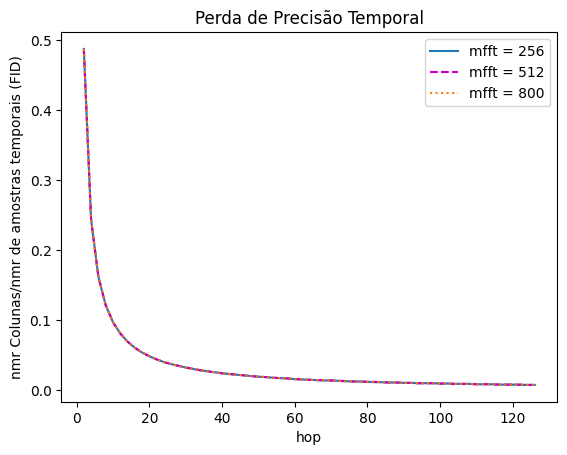

In [11]:
info_concentration_256 = []
info_concentration_512 = []
info_concentration_800 = []
for i in range(len(hop_)):
    info_concentration_256.append(spgram_hop_256['hop_'+str(hop_[i])][0].shape[2]/gt_fids.shape[1])
    info_concentration_512.append(spgram_hop_512['hop_'+str(hop_[i])][0].shape[2]/gt_fids.shape[1])
    info_concentration_800.append(spgram_hop_800['hop_'+str(hop_[i])][0].shape[2]/gt_fids.shape[1])

plt.plot(hop_,info_concentration_256,label = 'mfft = 256')
plt.plot(hop_,info_concentration_512,linestyle='dashed',label = 'mfft = 512',color='m')
plt.plot(hop_,info_concentration_800,linestyle='dotted',label = 'mfft = 800')
plt.ylabel('nmr Colunas/nmr de amostras temporais (FID)')
plt.xlabel('hop')
plt.title('Perda de Precisão Temporal')
plt.legend(loc='upper right')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_loss_time_precision.png')

Observação visual: 

Mudanças nas listras dos picos e na quantidade dos picos "fantasmas": observadas para os dois.

Não se nota diferença entre 512 e 800.


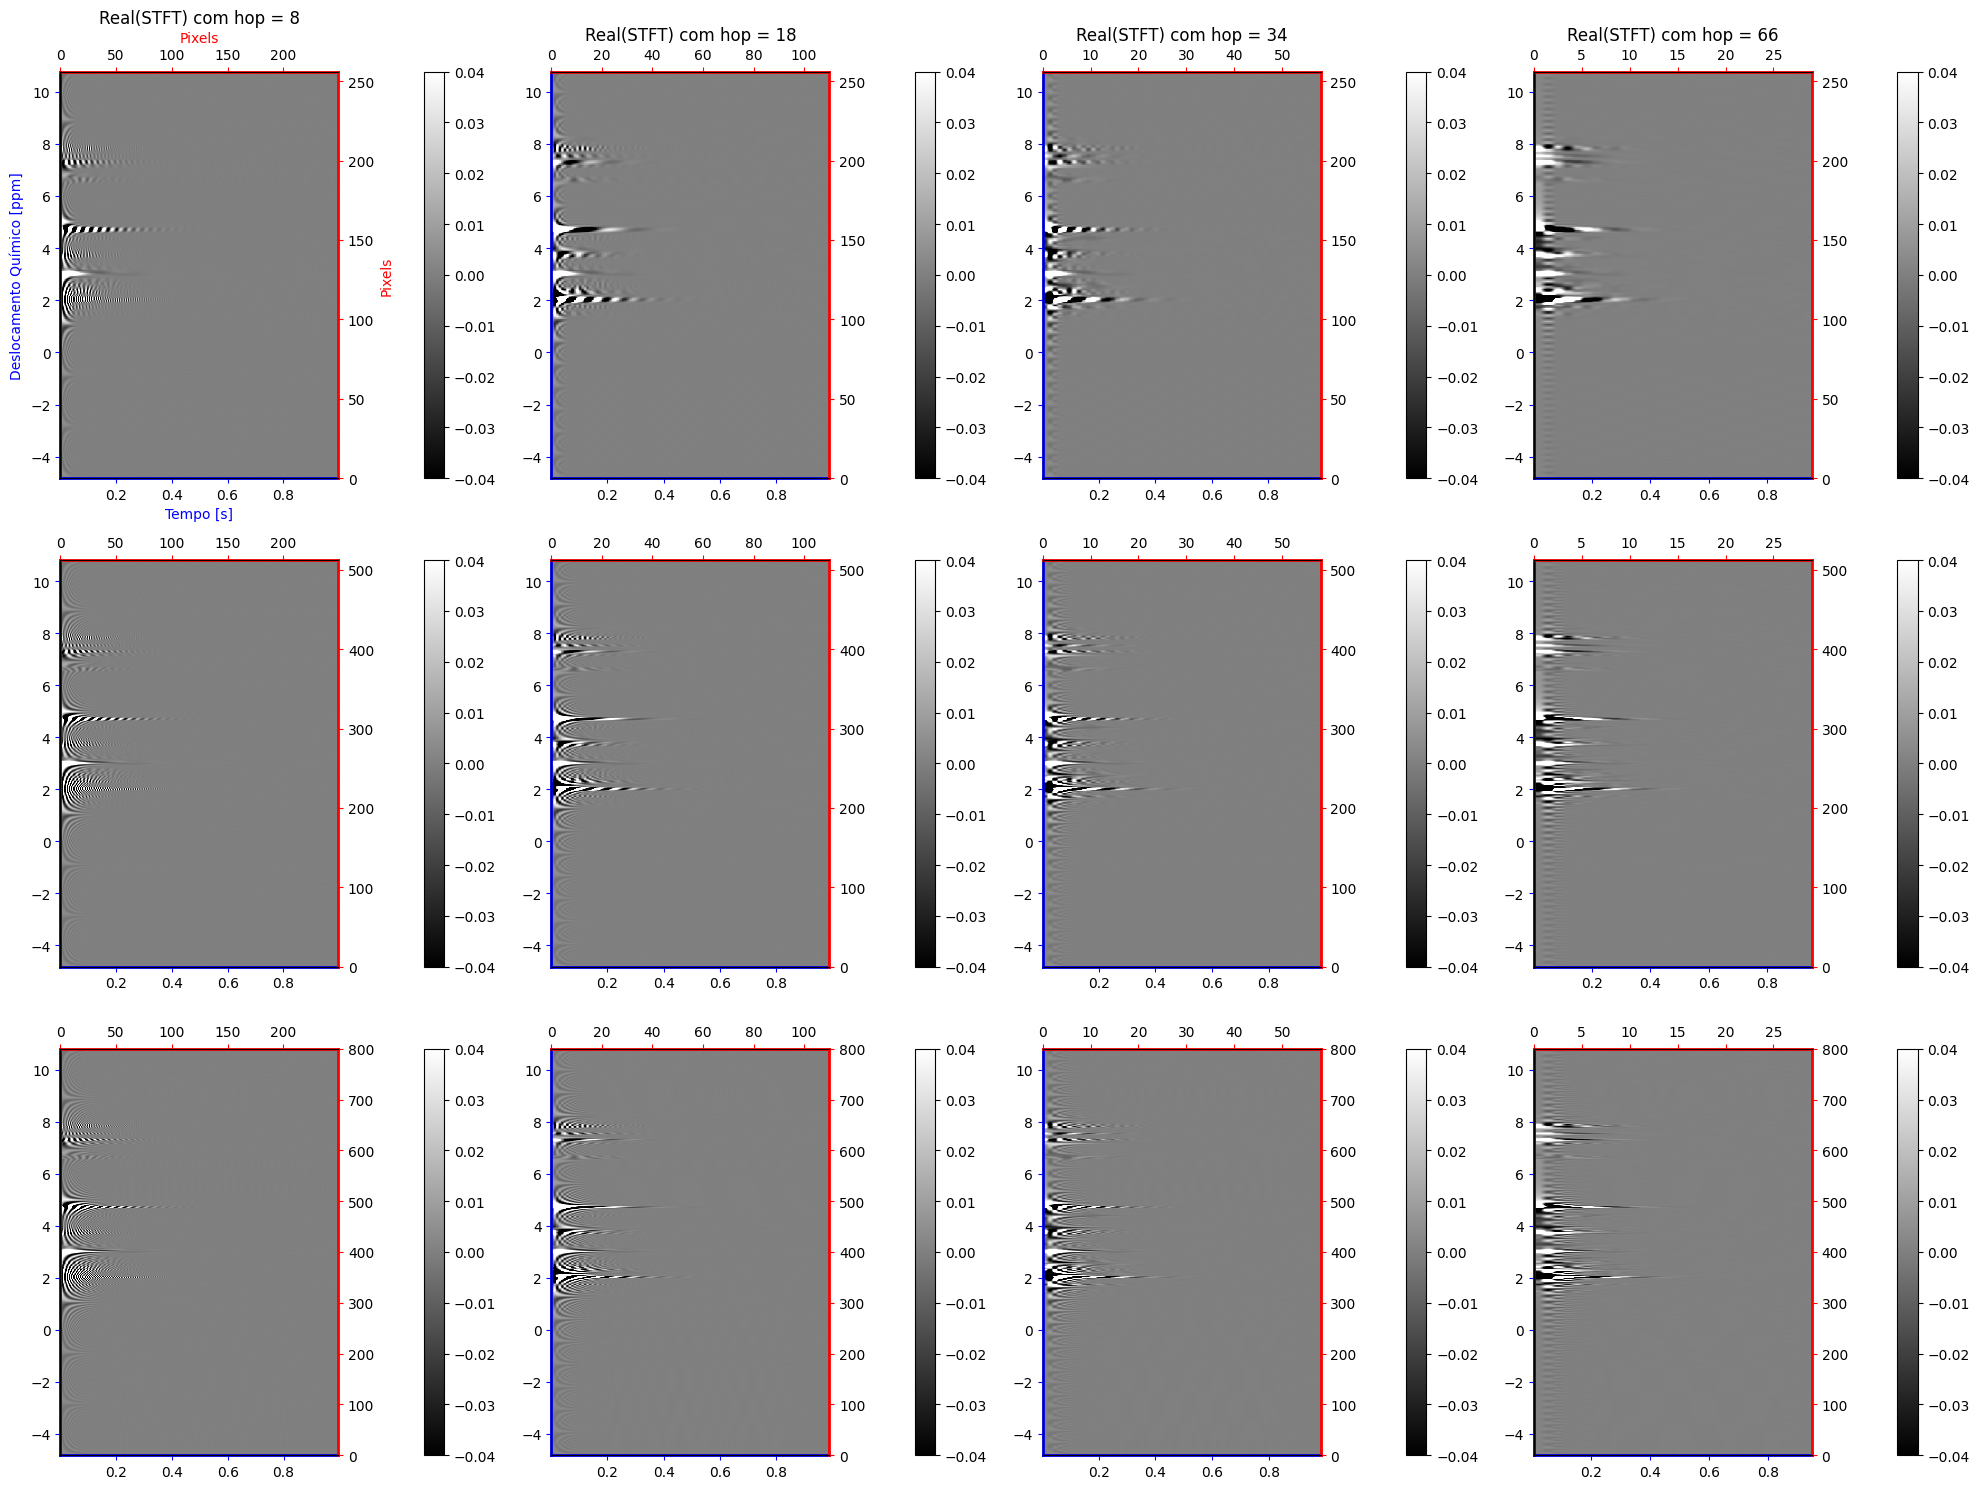

In [12]:
fig,ax = plt.subplots(3,4,figsize=(20,15))
im = ax.flat[0].imshow(np.real(spgram_hop_256['hop_'+str(hop_[3])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_256['hop_'+str(hop_[3])][-1][0],spgram_hop_256['hop_'+str(hop_[3])][-1][-1],spgram_hop_256['hop_'+str(hop_[3])][2][-1],spgram_hop_256['hop_'+str(hop_[3])][2][0]))
im = ax.flat[1].imshow(np.real(spgram_hop_256['hop_'+str(hop_[8])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_256['hop_'+str(hop_[8])][-1][0],spgram_hop_256['hop_'+str(hop_[8])][-1][-1],spgram_hop_256['hop_'+str(hop_[8])][2][-1],spgram_hop_256['hop_'+str(hop_[8])][2][0]))
im = ax.flat[2].imshow(np.real(spgram_hop_256['hop_'+str(hop_[16])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_256['hop_'+str(hop_[16])][-1][0],spgram_hop_256['hop_'+str(hop_[16])][-1][-1],spgram_hop_256['hop_'+str(hop_[16])][2][-1],spgram_hop_256['hop_'+str(hop_[16])][2][0]))
im = ax.flat[3].imshow(np.real(spgram_hop_256['hop_'+str(hop_[32])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_256['hop_'+str(hop_[32])][-1][0],spgram_hop_256['hop_'+str(hop_[32])][-1][-1],spgram_hop_256['hop_'+str(hop_[32])][2][-1],spgram_hop_256['hop_'+str(hop_[32])][2][0]))
im =ax.flat[4].imshow(np.real(spgram_hop_512['hop_'+str(hop_[3])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_512['hop_'+str(hop_[3])][-1][0],spgram_hop_512['hop_'+str(hop_[3])][-1][-1],spgram_hop_512['hop_'+str(hop_[3])][2][-1],spgram_hop_512['hop_'+str(hop_[3])][2][0]))
im =ax.flat[5].imshow(np.real(spgram_hop_512['hop_'+str(hop_[8])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_512['hop_'+str(hop_[8])][-1][0],spgram_hop_512['hop_'+str(hop_[8])][-1][-1],spgram_hop_512['hop_'+str(hop_[8])][2][-1],spgram_hop_512['hop_'+str(hop_[8])][2][0]))
im = ax.flat[6].imshow(np.real(spgram_hop_512['hop_'+str(hop_[16])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_512['hop_'+str(hop_[16])][-1][0],spgram_hop_512['hop_'+str(hop_[16])][-1][-1],spgram_hop_512['hop_'+str(hop_[16])][2][-1],spgram_hop_512['hop_'+str(hop_[16])][2][0]))
im = ax.flat[7].imshow(np.real(spgram_hop_512['hop_'+str(hop_[32])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_512['hop_'+str(hop_[32])][-1][0],spgram_hop_512['hop_'+str(hop_[32])][-1][-1],spgram_hop_512['hop_'+str(hop_[32])][2][-1],spgram_hop_512['hop_'+str(hop_[32])][2][0]))
im =ax.flat[8].imshow(np.real(spgram_hop_800['hop_'+str(hop_[3])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_800['hop_'+str(hop_[3])][-1][0],spgram_hop_800['hop_'+str(hop_[3])][-1][-1],spgram_hop_800['hop_'+str(hop_[3])][2][-1],spgram_hop_800['hop_'+str(hop_[3])][2][0]))
im =ax.flat[9].imshow(np.real(spgram_hop_800['hop_'+str(hop_[8])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_800['hop_'+str(hop_[8])][-1][0],spgram_hop_800['hop_'+str(hop_[8])][-1][-1],spgram_hop_800['hop_'+str(hop_[8])][2][-1],spgram_hop_800['hop_'+str(hop_[8])][2][0]))
im = ax.flat[10].imshow(np.real(spgram_hop_800['hop_'+str(hop_[16])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_800['hop_'+str(hop_[16])][-1][0],spgram_hop_800['hop_'+str(hop_[16])][-1][-1],spgram_hop_800['hop_'+str(hop_[16])][2][-1],spgram_hop_800['hop_'+str(hop_[16])][2][0]))
im = ax.flat[11].imshow(np.real(spgram_hop_800['hop_'+str(hop_[32])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_hop_800['hop_'+str(hop_[32])][-1][0],spgram_hop_800['hop_'+str(hop_[32])][-1][-1],spgram_hop_800['hop_'+str(hop_[32])][2][-1],spgram_hop_800['hop_'+str(hop_[32])][2][0]))

hop_plot = [3,8,16,32,3,8,16,32,3,8,16,32]
for i in range(3):
    for j in range(4):
        fig.colorbar(im, ax=ax[i,j], pad = 0.2)
for i in range(12):
    par1 = ax.flat[i].twiny()  # Additional x-axis
    par2 = ax.flat[i].twinx()  # Additional y-axis
    if i < 4:
        ax.flat[i].set_title('Real(STFT) com hop = '+str(hop_[hop_plot[i]]))
    if  i == 0:
        ax.flat[i].set_xlabel('Tempo [s]')
        ax.flat[i].set_ylabel('Deslocamento Químico [ppm]')
        ax.flat[i].xaxis.label.set_color('b')
        ax.flat[i].yaxis.label.set_color('b')
    ax.flat[i].spines['left'].set_visible(True)
    ax.flat[i].spines['bottom'].set_visible(True)
    ax.flat[i].spines['left'].set_color('b')
    ax.flat[i].spines['bottom'].set_color('b')
    ax.flat[i].spines['left'].set_linewidth(2)
    ax.flat[i].spines['bottom'].set_linewidth(2)
    # Set the position of the additional axes
    par1.spines['top'].set_position(('axes', 1))
    par2.spines['right'].set_position(('axes', 1))
    # Customize the additional axes
    if i < 4:
        par1.set_xlim(0,spgram_hop_256['hop_'+str(hop_[hop_plot[i]])][0].shape[2])
        par2.set_ylim(0,spgram_hop_256['hop_'+str(hop_[hop_plot[i]])][0].shape[1])
    elif i < 8:
        par1.set_xlim(0,spgram_hop_512['hop_'+str(hop_[hop_plot[i]])][0].shape[2])
        par2.set_ylim(0,spgram_hop_512['hop_'+str(hop_[hop_plot[i]])][0].shape[1])
    else:
        par1.set_xlim(0,spgram_hop_800['hop_'+str(hop_[hop_plot[i]])][0].shape[2])
        par2.set_ylim(0,spgram_hop_800['hop_'+str(hop_[hop_plot[i]])][0].shape[1])
    if i == 0:
        par1.set_xlabel("Pixels")
        par2.set_ylabel("Pixels")
        par1.xaxis.label.set_color('r')
        par2.yaxis.label.set_color('r')
    # Turn off unwanted spines for clarity
    par1.spines['top'].set_visible(True)
    par2.spines['right'].set_visible(True)
    par2.spines['right'].set_color('r')
    par1.spines['top'].set_color('r')
    par2.spines['right'].set_linewidth(2)
    par1.spines['top'].set_linewidth(2)
    # Synchronize the tick positions of the host and the twin axes
    ax.flat[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False,color='b')
    par1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True,color ='r')
    ax.flat[i].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False,color='b')
    par2.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True,color='r')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_examples.png')

Algumas colunas e linhas de interesse na análise dos espectrogramas:

In [8]:
list_of_t_spects_256 = []
list_of_ppm_spects_256 = []
for i in range(hop_.shape[0]):
    list_of_t_spects_256.append(spgram_hop_256['hop_'+str(hop_[i])][-1])
    list_of_ppm_spects_256.append(spgram_hop_256['hop_'+str(hop_[i])][2])
idx_time_0d05_256 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_256,time_point=0.05)
idx_time_0d4_256 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_256,time_point=0.4)
idx_time_0d6_256 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_256,time_point=0.6)
idx_freq_0ppm_256 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_256,ppm_point=0)
idx_freq_1ppm_256 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_256,ppm_point=1)
idx_freq_4ppm_256 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_256,ppm_point=4)
idx_freq_8ppm_256 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_256,ppm_point=8)
idx_freq_8d5ppm_256 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_256,ppm_point=8.5)
idx_freq_NAA_256 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_256,ppm_point=2.02)
idx_freq_GABA_256 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_256,ppm_point=3.00)
idx_freq_Glx_256 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_256,ppm_point=3.75)

In [9]:
list_of_t_spects_512 = []
list_of_ppm_spects_512 = []
for i in range(hop_.shape[0]):
    list_of_t_spects_512.append(spgram_hop_512['hop_'+str(hop_[i])][-1])
    list_of_ppm_spects_512.append(spgram_hop_512['hop_'+str(hop_[i])][2])
idx_time_0d05_512 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_512,time_point=0.05)
idx_time_0d4_512 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_512,time_point=0.4)
idx_time_0d6_512 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_512,time_point=0.6)
idx_freq_0ppm_512 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_512,ppm_point=0)
idx_freq_1ppm_512 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_512,ppm_point=1)
idx_freq_4ppm_512 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_512,ppm_point=4)
idx_freq_8ppm_512 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_512,ppm_point=8)
idx_freq_8d5ppm_512 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_512,ppm_point=8.5)
idx_freq_NAA_512 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_512,ppm_point=2.02)
idx_freq_GABA_512 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_512,ppm_point=3.00)
idx_freq_Glx_512 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_512,ppm_point=3.75)

In [10]:
list_of_t_spects_800 = []
list_of_ppm_spects_800 = []
for i in range(hop_.shape[0]):
    list_of_t_spects_800.append(spgram_hop_800['hop_'+str(hop_[i])][-1])
    list_of_ppm_spects_800.append(spgram_hop_800['hop_'+str(hop_[i])][2])
idx_time_0d05_800 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_800,time_point=0.05)
idx_time_0d4_800 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_800,time_point=0.4)
idx_time_0d6_800 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_800,time_point=0.6)
idx_freq_0ppm_800 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_800,ppm_point=0)
idx_freq_1ppm_800 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_800,ppm_point=1)
idx_freq_4ppm_800 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_800,ppm_point=4)
idx_freq_8ppm_800 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_800,ppm_point=8)
idx_freq_8d5ppm_800 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_800,ppm_point=8.5)
idx_freq_NAA_800 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_800,ppm_point=2.02)
idx_freq_GABA_800 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_800,ppm_point=3.00)
idx_freq_Glx_800 = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_800,ppm_point=3.75)

Espectrogramas concatenados:

Até hop = 34 (terceira imagem), os blocos na região branca parecem ter o mesmo número para os três casos, depois para mfft = 256 é difícil observar. Olhando as listras de NAA, a partir de hop = 34 é possível contar a quantidade de listras e é igual para os três casos. 

Pico de GABA para mfft = 256 é mais comprimido, parece que a borda se alonga mais, tem menor resolução. Envoltório preto em torno do pico de GABA fica mais bem definido. 

Picos se alongam mais para mfft=800, mesmo os fantasmas. Valores demoram mais a decair. Isso é visível tanto pela parte real quanto pela parte absoluta do real. 

É visível que os picos são mais "gordinhos" para mfft=256, mas a diferença entre mft=512 e 800 é pouco visível.

In [17]:
aux_concat = (np.arange(4,len(hop_),6)).tolist()
spgram_hop_concat_256 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_256,list_time_idx=idx_time_0d4_256,fid_idx_plot=0)
spgram_hop_concat_512 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_512,list_time_idx=idx_time_0d4_512,fid_idx_plot=0)
spgram_hop_concat_800 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_800,list_time_idx=idx_time_0d4_800,fid_idx_plot=0)

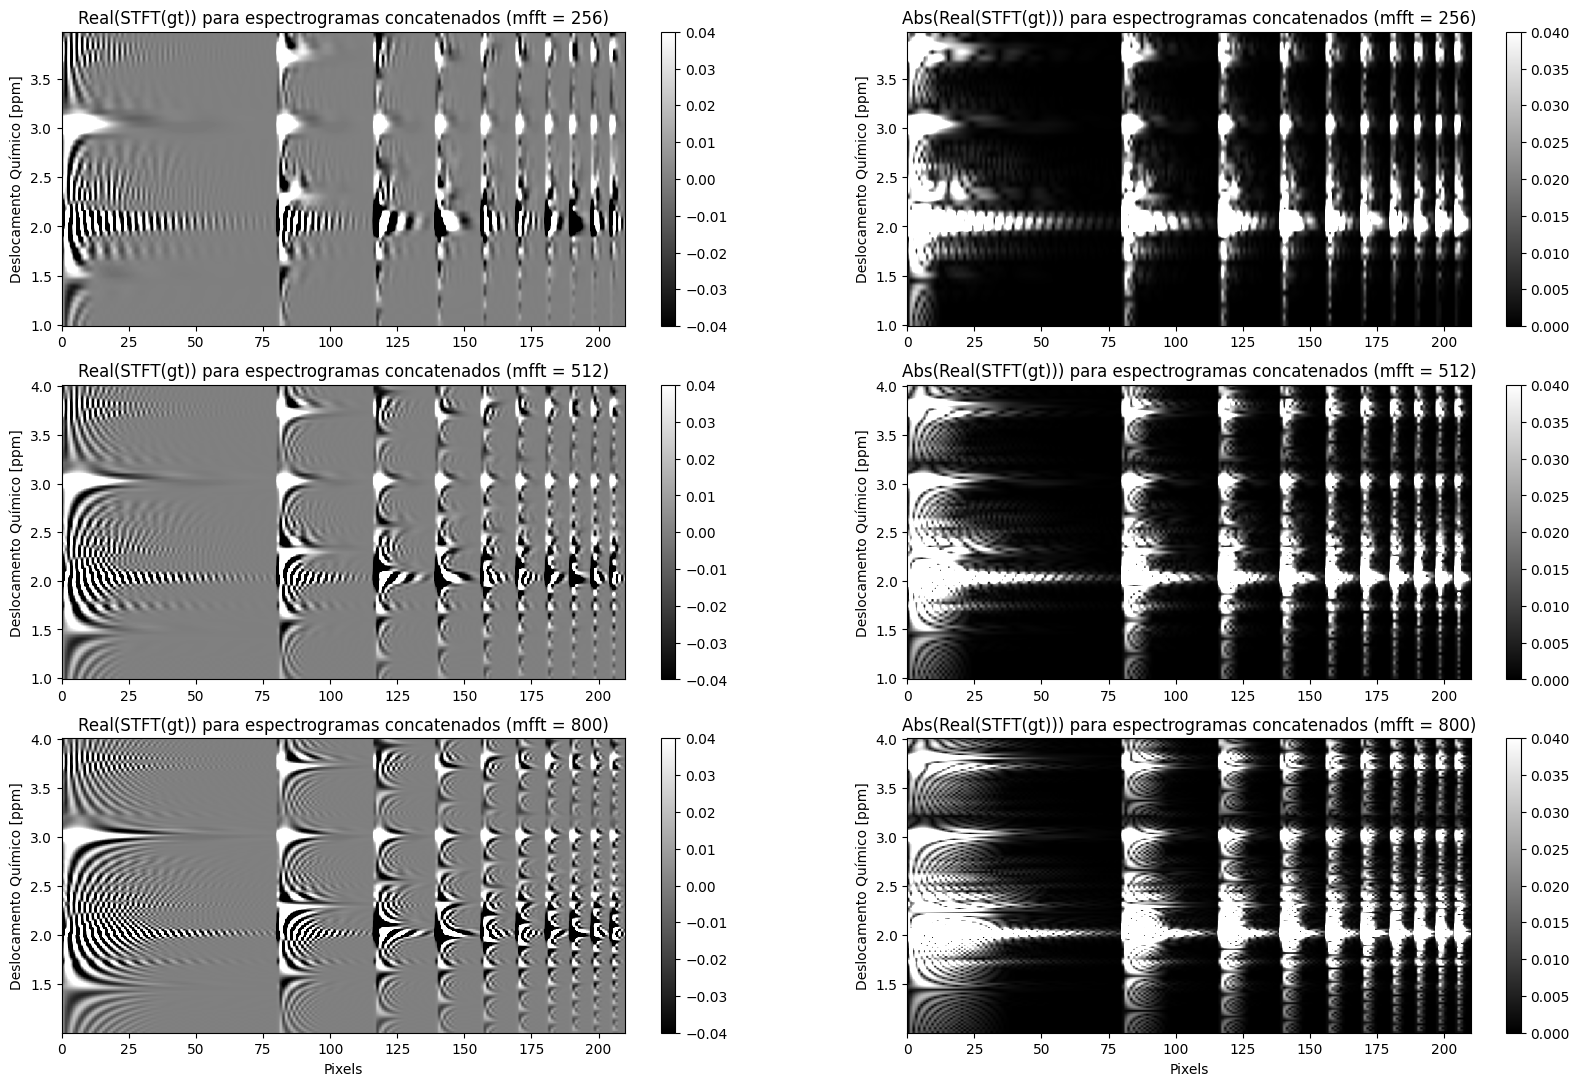

In [20]:
fig,ax = plt.subplots(3,2,figsize=(20,13))
im = ax[0,0].imshow(np.real(spgram_hop_concat_256[idx_freq_1ppm_256[0]:idx_freq_4ppm_256[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_256.shape[-1],np.flip(spgram_hop_256['hop_'+str(hop_[0])][2])[idx_freq_1ppm_256[0]],np.flip(spgram_hop_256['hop_'+str(hop_[0])][2])[idx_freq_4ppm_256[0]]))
fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Real(STFT(gt)) para espectrogramas concatenados (mfft = 256)')
im = ax[0,1].imshow(np.abs(np.real(spgram_hop_concat_256[idx_freq_1ppm_256[0]:idx_freq_4ppm_256[0],:])), origin='lower', aspect='auto',cmap='gray',vmin=0,vmax=0.04,
          extent = (0,spgram_hop_concat_256.shape[-1],np.flip(spgram_hop_256['hop_'+str(hop_[0])][2])[idx_freq_1ppm_256[0]],np.flip(spgram_hop_256['hop_'+str(hop_[0])][2])[idx_freq_4ppm_256[0]]))
fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Abs(Real(STFT(gt))) para espectrogramas concatenados (mfft = 256)')
im = ax[1,0].imshow(np.real(spgram_hop_concat_512[idx_freq_1ppm_512[0]:idx_freq_4ppm_512[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_512.shape[-1],np.flip(spgram_hop_512['hop_'+str(hop_[0])][2])[idx_freq_1ppm_512[0]],np.flip(spgram_hop_512['hop_'+str(hop_[0])][2])[idx_freq_4ppm_512[0]]))
fig.colorbar(im, ax=ax[1,0])
ax[1,0].set_title('Real(STFT(gt)) para espectrogramas concatenados (mfft = 512)')
im = ax[1,1].imshow(np.abs(np.real(spgram_hop_concat_512[idx_freq_1ppm_512[0]:idx_freq_4ppm_512[0],:])), origin='lower', aspect='auto',cmap='gray',vmin=0,vmax=0.04,
          extent = (0,spgram_hop_concat_512.shape[-1],np.flip(spgram_hop_512['hop_'+str(hop_[0])][2])[idx_freq_1ppm_512[0]],np.flip(spgram_hop_512['hop_'+str(hop_[0])][2])[idx_freq_4ppm_512[0]]))
fig.colorbar(im, ax=ax[1,1])
ax[1,1].set_title('Abs(Real(STFT(gt))) para espectrogramas concatenados (mfft = 512)')
im = ax[2,0].imshow(np.real(spgram_hop_concat_800[idx_freq_1ppm_800[0]:idx_freq_4ppm_800[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_800.shape[-1],np.flip(spgram_hop_800['hop_'+str(hop_[0])][2])[idx_freq_1ppm_800[0]],np.flip(spgram_hop_800['hop_'+str(hop_[0])][2])[idx_freq_4ppm_800[0]]))
fig.colorbar(im, ax=ax[2,0])
ax[2,0].set_title('Real(STFT(gt)) para espectrogramas concatenados (mfft = 800)')
im = ax[2,1].imshow(np.abs(np.real(spgram_hop_concat_800[idx_freq_1ppm_800[0]:idx_freq_4ppm_800[0],:])), origin='lower', aspect='auto',cmap='gray',vmin=0,vmax=0.04,
          extent = (0,spgram_hop_concat_800.shape[-1],np.flip(spgram_hop_800['hop_'+str(hop_[0])][2])[idx_freq_1ppm_800[0]],np.flip(spgram_hop_800['hop_'+str(hop_[0])][2])[idx_freq_4ppm_800[0]]))
fig.colorbar(im, ax=ax[2,1])
ax[2,1].set_title('Abs(Real(STFT(gt))) para espectrogramas concatenados (mfft = 800)')
for i in range(6):
    ax.flat[i].set_ylabel('Deslocamento Químico [ppm]')
for i in range(4,6):
    ax.flat[i].set_xlabel('Pixels')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_concatenated_examples.png')

Perfil NAA: Similar para os três, i.e. mesma quantidade de listras. Porém a intensidade de alguns picos e vales aumenta com mfft. 

Perfil Glx: Mais similar conforme hop aumenta, nesse caso intensidade de alguns picos e vales descresce com mfft. Para hop = 10, nota-se um desalinhamento entre as oscilações de cada valor de mfft. Para os demais valores de hop, o perfil para mfft=800 apresenta um pico invertido com relação aos demais.

Pefil GABA: O GABA cai mais lentamente conforme mfft aumenta, e atinge uma intensidade menor.

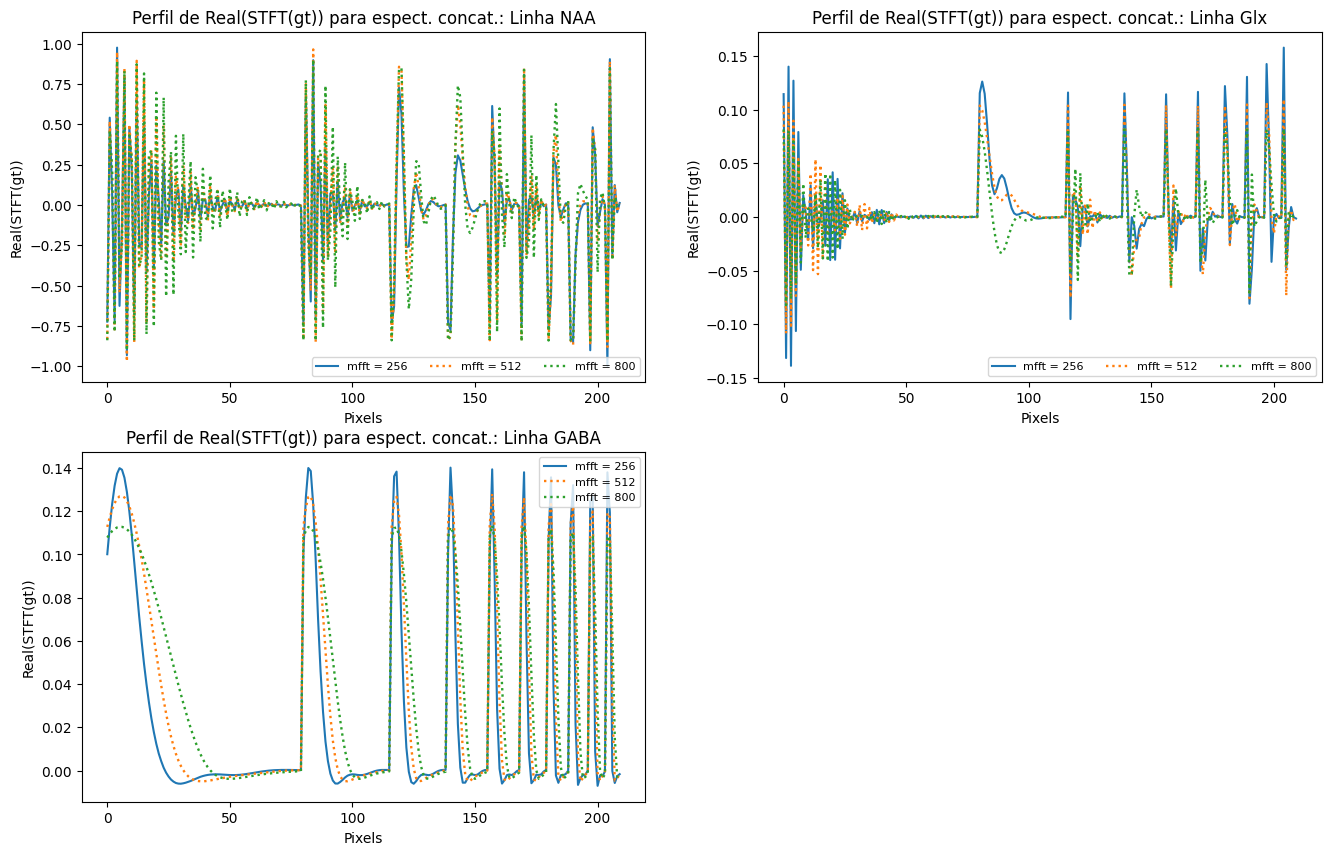

In [24]:
fig, ax = plt.subplots(2,2,figsize=(16,10))
ax.flat[0].plot(np.real(spgram_hop_concat_256[idx_freq_NAA_256[0],:]),label='mfft = 256')
ax.flat[0].plot(np.real(spgram_hop_concat_512[idx_freq_NAA_512[0],:]),linestyle='dotted',linewidth=1.7, label='mfft = 512')
ax.flat[0].plot(np.real(spgram_hop_concat_800[idx_freq_NAA_800[0],:]),linestyle='dotted',linewidth=1.7, label='mfft = 800')
ax.flat[0].set_xlabel('Pixels')
ax.flat[0].set_ylabel('Real(STFT(gt))')
ax.flat[0].set_title('Perfil de Real(STFT(gt)) para espect. concat.: Linha NAA')
ax.flat[0].legend(loc='lower right', ncols = 3, fontsize=8)
ax.flat[1].plot(np.real(spgram_hop_concat_256[idx_freq_Glx_256[0],:]),label='mfft = 256')
ax.flat[1].plot(np.real(spgram_hop_concat_512[idx_freq_Glx_512[0],:]),linestyle = 'dotted', linewidth=1.7, label='mfft = 512')
ax.flat[1].plot(np.real(spgram_hop_concat_800[idx_freq_Glx_800[0],:]),linestyle = 'dotted', linewidth=1.7, label='mfft = 800')
ax.flat[1].set_xlabel('Pixels')
ax.flat[1].set_ylabel('Real(STFT(gt))')
ax.flat[1].set_title('Perfil de Real(STFT(gt)) para espect. concat.: Linha Glx')
ax.flat[1].legend(loc='lower right', ncols = 3, fontsize=8)
ax.flat[2].plot(np.real(spgram_hop_concat_256[idx_freq_GABA_256[0],:]),label='mfft = 256')
ax.flat[2].plot(np.real(spgram_hop_concat_512[idx_freq_GABA_512[0],:]),linestyle = 'dotted', linewidth=1.7, label='mfft = 512')
ax.flat[2].plot(np.real(spgram_hop_concat_800[idx_freq_GABA_800[0],:]),linestyle = 'dotted', linewidth=1.7, label='mfft = 800')
ax.flat[2].set_xlabel('Pixels')
ax.flat[2].set_ylabel('Real(STFT(gt))')
ax.flat[2].set_title('Perfil de Real(STFT(gt)) para espect. concat.: Linha GABA')
ax.flat[2].legend(loc='upper right', fontsize=8)
ax.flat[3].axis('off')
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_concatenated_profile.png')

Projeção no eixo da frequência:

In [25]:
plot_id = [0,29,43,50,59]
list_projections_abs_256 = []
list_projections_real_256 = []
list_projections_abs_512 = []
list_projections_real_512 = []
list_projections_abs_800 = []
list_projections_real_800 = []
idx_fwhm_256 = {}
idx_fwhm_real_256 = {}
idx_fwhm_512 = {}
idx_fwhm_real_512 = {}
idx_fwhm_800 = {}
idx_fwhm_real_800 = {}
list_of_ppm_spects_256 = []
idx_freq_NAA_aux_256 = []
idx_freq_GABA_aux_256 = []
idx_freq_Glx_aux_256 = []
list_of_ppm_spects_512 = []
idx_freq_NAA_aux_512 = []
idx_freq_GABA_aux_512 = []
idx_freq_Glx_aux_512 = []
list_of_ppm_spects_800 = []
idx_freq_NAA_aux_800 = []
idx_freq_GABA_aux_800 = []
idx_freq_Glx_aux_800 = []
for i in range(len(plot_id)):
    list_projections_abs_256.append(np.sum(np.abs(np.real(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][0])), axis = 2))
    list_projections_real_256.append(np.sum(np.real(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][0]), axis = 2))
    list_projections_abs_512.append(np.sum(np.abs(np.real(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][0])), axis = 2))
    list_projections_real_512.append(np.sum(np.real(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][0]), axis = 2))
    list_projections_abs_800.append(np.sum(np.abs(np.real(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][0])), axis = 2))
    list_projections_real_800.append(np.sum(np.real(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][0]), axis = 2))
    idx_fwhm_256['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_real_256['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_512['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_real_512['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_800['hop_'+str(hop_[plot_id[i]])] = {}
    idx_fwhm_real_800['hop_'+str(hop_[plot_id[i]])] = {}
    list_of_ppm_spects_256.append(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])
    idx_freq_NAA_aux_256.append(idx_freq_NAA_256[i])
    idx_freq_GABA_aux_256.append(idx_freq_GABA_256[i])
    idx_freq_Glx_aux_256.append(idx_freq_Glx_256[i])
    list_of_ppm_spects_512.append(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])
    idx_freq_NAA_aux_512.append(idx_freq_NAA_512[i])
    idx_freq_GABA_aux_512.append(idx_freq_GABA_512[i])
    idx_freq_Glx_aux_512.append(idx_freq_Glx_512[i])
    list_of_ppm_spects_800.append(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])
    idx_freq_NAA_aux_800.append(idx_freq_NAA_800[i])
    idx_freq_GABA_aux_800.append(idx_freq_GABA_800[i])
    idx_freq_Glx_aux_800.append(idx_freq_Glx_800[i])

print('starting 256 data')
aux, aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_256,list_peak_idx=idx_freq_NAA_aux_256,list_ppm=list_of_ppm_spects_256,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
aux, aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_256,list_peak_idx=idx_freq_GABA_aux_256,list_ppm=list_of_ppm_spects_256,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_256,list_peak_idx=idx_freq_Glx_aux_256,list_ppm=list_of_ppm_spects_256,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

aux, aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_256,list_peak_idx=idx_freq_NAA_aux_256,list_ppm=list_of_ppm_spects_256,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
aux, aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_256,list_peak_idx=idx_freq_GABA_aux_256,list_ppm=list_of_ppm_spects_256,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_256,list_peak_idx=idx_freq_Glx_aux_256,list_ppm=list_of_ppm_spects_256,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

print('adjusting for 256 data')
for i in range(len(plot_id)):
    idx_fwhm_256['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm_256['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm_256['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real_256['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real_256['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real_256['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_real[i]

print('starting 512 data')
aux, aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_512,list_peak_idx=idx_freq_NAA_aux_512,list_ppm=list_of_ppm_spects_512,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
aux, aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_512,list_peak_idx=idx_freq_GABA_aux_512,list_ppm=list_of_ppm_spects_512,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_512,list_peak_idx=idx_freq_Glx_aux_512,list_ppm=list_of_ppm_spects_512,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

aux, aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_512,list_peak_idx=idx_freq_NAA_aux_512,list_ppm=list_of_ppm_spects_512,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
aux, aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_512,list_peak_idx=idx_freq_GABA_aux_512,list_ppm=list_of_ppm_spects_512,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_512,list_peak_idx=idx_freq_Glx_aux_512,list_ppm=list_of_ppm_spects_512,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

print('adjusting for 512 data')
for i in range(len(plot_id)):
    idx_fwhm_512['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm_512['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm_512['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real_512['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real_512['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real_512['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_real[i]

print('starting 800 data')
aux, aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_800,list_peak_idx=idx_freq_NAA_aux_800,list_ppm=list_of_ppm_spects_800,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
aux, aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_800,list_peak_idx=idx_freq_GABA_aux_800,list_ppm=list_of_ppm_spects_800,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_800,list_peak_idx=idx_freq_Glx_aux_800,list_ppm=list_of_ppm_spects_800,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

aux, aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_800,list_peak_idx=idx_freq_NAA_aux_800,list_ppm=list_of_ppm_spects_800,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
aux, aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_800,list_peak_idx=idx_freq_GABA_aux_800,list_ppm=list_of_ppm_spects_800,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_800,list_peak_idx=idx_freq_Glx_aux_800,list_ppm=list_of_ppm_spects_800,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

print('adjusting for 800 data')
for i in range(len(plot_id)):
    idx_fwhm_800['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm_800['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm_800['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real_800['hop_'+str(hop_[plot_id[i]])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real_800['hop_'+str(hop_[plot_id[i]])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real_800['hop_'+str(hop_[plot_id[i]])]['Glx'] = aux_idx_Glx_real[i]

starting 256 data
adjusting for 256 data
starting 512 data
adjusting for 512 data
starting 800 data
adjusting for 800 data


O que se conclui de proj(abs(real)):

- NAA: tende a ser constante com hop para os três valores de mfft, quanto maior mfft, menor FWHM (mais fino o pico).
- GABA: comportamento depende de mfft. Para mfft=256, constante para todo hop, já para mfft=512, FWHM é constante até hop = 98, depois decai com hop. Para mfft=800, FWHM decai com hop. Para esse valor, o formato do pico é distorcido, o que pode ser a origem desse resultado. Visualmente, e pelas métricas, FWHM diminui com mfft.
- Glx: conforme mfft aumenta, o formato dos picos que formam o Glx se tornam mais bem definidos, e a métrica FWHM varia com menos intensidade, e apresenta valor médio menor.

O que se conclui de proj(real):
- NAA: o formato do pico é impactado pela região ao redor dele, a qual varia bastante com hop e com mfft, provavelmente devido a mudança da intensidade (decaimento) dos picos ao redor que nota-se com o aumento do mfft. Apesar dessa mudança com mfft, as formas observadas apra cada hop são parecidas para mfft = 512 e 800. A irregularidade da forma do pico leva a oscilações na métrica FWHM, mas em média ela diminui com o aumento do mfft e tem média constante com hop.
- GABA: o pico fica bem definido nesse caso, e se torna o maior pico da projeção nesse caso. A medição do FWHM não varia com hop para nenhum mfft, mas diminui com o mfft. 
- Glx: Similar ao NAA, o hop afeta muito no formato do pico, e o mfft também causa menores alteraçãoes. No geral, a medida diminui com mfft, mas para cada mfft tem média constante com hop.

Como indicado pelos estudos individuais, mfft impacta mais no valor medido de FWHM, e hop impacta no formato dos picos (e na qualidade da métrica). Para mfft=256, tem-se picos mais grossos e esse é o fator principal de mudança.

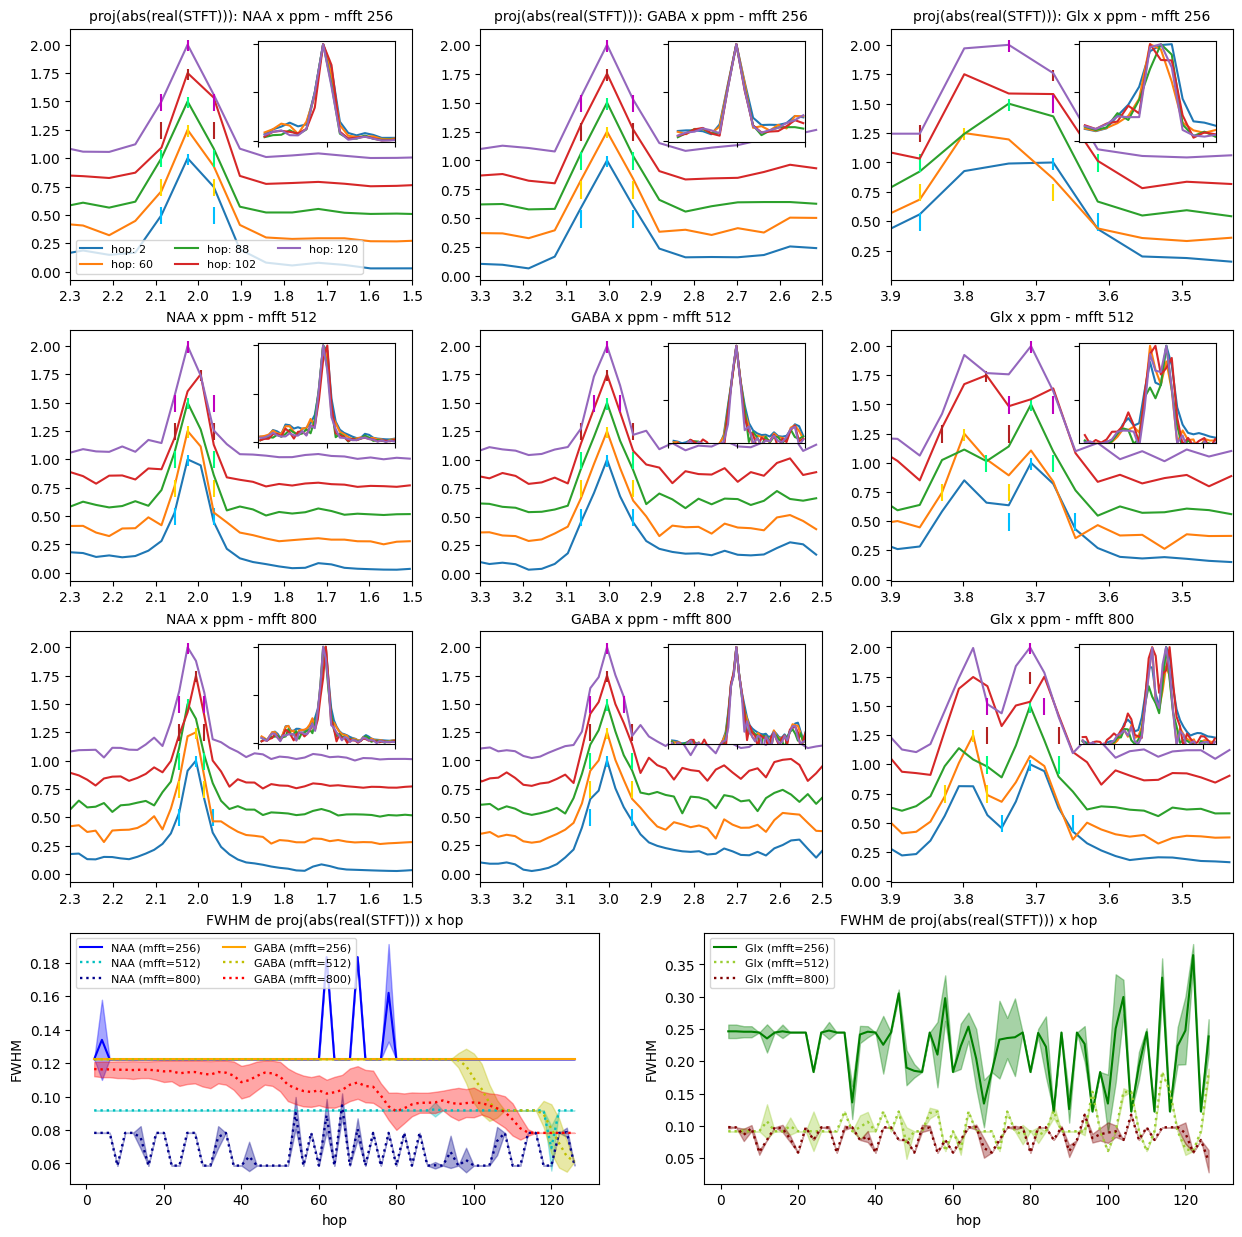

In [28]:
fig = plt.figure(figsize=(15, 15)) 

ax1 = plt.subplot2grid((4, 3), (0, 0))  
ax2 = plt.subplot2grid((4, 3), (0, 1))  
ax3 = plt.subplot2grid((4, 3), (0, 2)) 
ax6 = plt.subplot2grid((4, 3), (1, 0))  
ax7 = plt.subplot2grid((4, 3), (1, 1))  
ax8 = plt.subplot2grid((4, 3), (1, 2)) 
ax9 = plt.subplot2grid((4, 3), (2, 0))  
ax10 = plt.subplot2grid((4, 3), (2, 1))  
ax11 = plt.subplot2grid((4, 3), (2, 2)) 

ax4 = plt.subplot2grid((4, 2), (3, 0)) 
ax5 = plt.subplot2grid((4, 2), (3, 1))

axins1 = ax1.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins2 = ax2.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins3 = ax3.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins6 = ax6.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins7 = ax7.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(0.1,1.03), xticklabels=[], yticklabels=[])
axins8 = ax8.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(0.1,1.03), xticklabels=[], yticklabels=[])
axins9 = ax9.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins10 = ax10.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(0.1,1.03), xticklabels=[], yticklabels=[])
axins11 = ax11.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(0.1,1.03), xticklabels=[], yticklabels=[])

#plot_id = np.arange(0,len(hop_),10)
plot_id = [0,29,43,50,59]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
colors_sec = ['deepskyblue','gold','springgreen','firebrick','m']
for i in range(5):
    aux_256 = np.mean((np.sum(np.abs(np.real(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][0])),axis=2)),axis=0)
    aux_512 = np.mean((np.sum(np.abs(np.real(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][0])),axis=2)),axis=0)
    aux_800 = np.mean((np.sum(np.abs(np.real(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][0])),axis=2)),axis=0)
    aux1d5_256 = utils.give_idx_ppm_point(ppm_array=spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5_256 = utils.give_idx_ppm_point(ppm_array=spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5_256 = utils.give_idx_ppm_point(ppm_array=spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2_256 = utils.give_idx_ppm_point(ppm_array=spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43_256 = utils.give_idx_ppm_point(ppm_array=spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.43)
    aux1d5_512 = utils.give_idx_ppm_point(ppm_array=spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5_512 = utils.give_idx_ppm_point(ppm_array=spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5_512 = utils.give_idx_ppm_point(ppm_array=spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2_512 = utils.give_idx_ppm_point(ppm_array=spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43_512 = utils.give_idx_ppm_point(ppm_array=spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.43)
    aux1d5_800 = utils.give_idx_ppm_point(ppm_array=spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5_800 = utils.give_idx_ppm_point(ppm_array=spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5_800 = utils.give_idx_ppm_point(ppm_array=spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2_800 = utils.give_idx_ppm_point(ppm_array=spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43_800 = utils.give_idx_ppm_point(ppm_array=spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.43)
    ax1.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_256:aux2d5_256],aux_256[aux1d5_256:aux2d5_256]/np.max(aux_256[aux1d5_256:aux2d5_256])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax6.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_512:aux2d5_512],aux_512[aux1d5_512:aux2d5_512]/np.max(aux_512[aux1d5_512:aux2d5_512])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax9.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_800:aux2d5_800],aux_800[aux1d5_800:aux2d5_800]/np.max(aux_800[aux1d5_800:aux2d5_800])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax2.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_256:aux3d5_256],aux_256[aux2d5_256:aux3d5_256]/np.max(aux_256[aux2d5_256:aux3d5_256])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax7.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_512:aux3d5_512],aux_512[aux2d5_512:aux3d5_512]/np.max(aux_512[aux2d5_512:aux3d5_512])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax10.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_800:aux3d5_800],aux_800[aux2d5_800:aux3d5_800]/np.max(aux_800[aux2d5_800:aux3d5_800])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax3.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_256:aux4d2_256],aux_256[aux3d43_256:aux4d2_256]/np.max(aux_256[aux3d43_256:aux4d2_256])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax8.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_512:aux4d2_512],aux_512[aux3d43_512:aux4d2_512]/np.max(aux_512[aux3d43_512:aux4d2_512])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax11.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_800:aux4d2_800],aux_800[aux3d43_800:aux4d2_800]/np.max(aux_800[aux3d43_800:aux4d2_800])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    axins1.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_256:aux2d5_256],aux_256[aux1d5_256:aux2d5_256]/np.max(aux_256[aux1d5_256:aux2d5_256]), color=colors[i])
    axins6.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_512:aux2d5_512],aux_512[aux1d5_512:aux2d5_512]/np.max(aux_512[aux1d5_512:aux2d5_512]), color=colors[i])
    axins9.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_800:aux2d5_800],aux_800[aux1d5_800:aux2d5_800]/np.max(aux_800[aux1d5_800:aux2d5_800]), color=colors[i])
    axins2.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_256:aux3d5_256],aux_256[aux2d5_256:aux3d5_256]/np.max(aux_256[aux2d5_256:aux3d5_256]), color=colors[i])
    axins7.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_512:aux3d5_512],aux_512[aux2d5_512:aux3d5_512]/np.max(aux_512[aux2d5_512:aux3d5_512]), color=colors[i])
    axins10.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_800:aux3d5_800],aux_800[aux2d5_800:aux3d5_800]/np.max(aux_800[aux2d5_800:aux3d5_800]), color=colors[i])
    axins3.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_256:aux4d2_256],aux_256[aux3d43_256:aux4d2_256]/np.max(aux_256[aux3d43_256:aux4d2_256]), color=colors[i])
    axins8.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_512:aux4d2_512],aux_512[aux3d43_512:aux4d2_512]/np.max(aux_512[aux3d43_512:aux4d2_512]), color=colors[i])
    axins11.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_800:aux4d2_800],aux_800[aux3d43_800:aux4d2_800]/np.max(aux_800[aux3d43_800:aux4d2_800]), color=colors[i])
    aux_NAA = np.mean(idx_fwhm_256['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax1.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_256['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax2.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_256['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax3.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_NAA = np.mean(idx_fwhm_512['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax6.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_512['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax7.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_512['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax8.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_NAA = np.mean(idx_fwhm_800['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax9.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax9.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax9.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_800['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax10.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax10.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax10.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_800['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax11.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax11.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax11.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])


ax1.set_xlim(2.3,1.5) 
ax2.set_xlim(3.3,2.5)
ax3.set_xlim(3.9,3.43)  
ax1.legend(loc='lower left', ncols=3,fontsize=8)
ax1.set_title('proj(abs(real(STFT))): NAA x ppm - mfft 256',fontsize = 10)
ax2.set_title('proj(abs(real(STFT))): GABA x ppm - mfft 256',fontsize = 10)
ax3.set_title('proj(abs(real(STFT))): Glx x ppm - mfft 256',fontsize = 10)

ax6.set_xlim(2.3,1.5) 
ax7.set_xlim(3.3,2.5)
ax8.set_xlim(3.9,3.43)  
ax6.set_title('NAA x ppm - mfft 512',fontsize = 10)
ax7.set_title('GABA x ppm - mfft 512',fontsize = 10)
ax8.set_title('Glx x ppm - mfft 512',fontsize = 10)

ax9.set_xlim(2.3,1.5) 
ax10.set_xlim(3.3,2.5)
ax11.set_xlim(3.9,3.43)  
ax9.set_title('NAA x ppm - mfft 800',fontsize = 10)
ax10.set_title('GABA x ppm - mfft 800',fontsize = 10)
ax11.set_title('Glx x ppm - mfft 800',fontsize = 10)


ax4.plot(hop_,metrics_256['fwhm_hop']['NAA']['mean'],label='NAA (mfft=256)',color='b')
ax4.fill_between(hop_, np.array(metrics_256['fwhm_hop']['NAA']['mean']) - np.array(metrics_256['fwhm_hop']['NAA']['std']), 
                        np.array(metrics_256['fwhm_hop']['NAA']['mean']) + np.array(metrics_256['fwhm_hop']['NAA']['std']), alpha=0.35, color = 'b')
ax4.plot(hop_,metrics_512['fwhm_hop']['NAA']['mean'],label='NAA (mfft=512)',color='c',linestyle='dotted',linewidth=1.7)
ax4.fill_between(hop_, np.array(metrics_512['fwhm_hop']['NAA']['mean']) - np.array(metrics_512['fwhm_hop']['NAA']['std']), 
                        np.array(metrics_512['fwhm_hop']['NAA']['mean']) + np.array(metrics_512['fwhm_hop']['NAA']['std']), alpha=0.35, color = 'c')
ax4.plot(hop_,metrics_800['fwhm_hop']['NAA']['mean'],label='NAA (mfft=800)',color='darkblue',linestyle='dotted',linewidth=1.7)
ax4.fill_between(hop_, np.array(metrics_800['fwhm_hop']['NAA']['mean']) - np.array(metrics_800['fwhm_hop']['NAA']['std']), 
                        np.array(metrics_800['fwhm_hop']['NAA']['mean']) + np.array(metrics_800['fwhm_hop']['NAA']['std']), alpha=0.35, color = 'darkblue')
ax4.plot(hop_,metrics_256['fwhm_hop']['GABA']['mean'],label='GABA (mfft=256)',color='orange')
ax4.fill_between(hop_, np.array(metrics_256['fwhm_hop']['GABA']['mean']) - np.array(metrics_256['fwhm_hop']['GABA']['std']), 
                        np.array(metrics_256['fwhm_hop']['GABA']['mean']) + np.array(metrics_256['fwhm_hop']['GABA']['std']), alpha=0.35, color = 'orange')
ax4.plot(hop_,metrics_512['fwhm_hop']['GABA']['mean'],label='GABA (mfft=512)',color='y',linestyle='dotted',linewidth=1.7)
ax4.fill_between(hop_, np.array(metrics_512['fwhm_hop']['GABA']['mean']) - np.array(metrics_512['fwhm_hop']['GABA']['std']), 
                        np.array(metrics_512['fwhm_hop']['GABA']['mean']) + np.array(metrics_512['fwhm_hop']['GABA']['std']), alpha=0.35, color = 'y')
ax4.plot(hop_,metrics_800['fwhm_hop']['GABA']['mean'],label='GABA (mfft=800)',color='red',linestyle='dotted',linewidth=1.7)
ax4.fill_between(hop_, np.array(metrics_800['fwhm_hop']['GABA']['mean']) - np.array(metrics_800['fwhm_hop']['GABA']['std']), 
                        np.array(metrics_800['fwhm_hop']['GABA']['mean']) + np.array(metrics_800['fwhm_hop']['GABA']['std']), alpha=0.35, color = 'red')
ax4.set_title('FWHM de proj(abs(real(STFT))) x hop',fontsize = 10)
ax4.set_xlabel('hop',fontsize = 10)
ax4.set_ylabel('FWHM',fontsize = 10)
ax4.legend(loc='upper left', ncols = 2, fontsize=8)
ax5.plot(hop_,metrics_256['fwhm_hop']['Glx']['mean'],label='Glx (mfft=256)',color='g')
ax5.fill_between(hop_, np.array(metrics_256['fwhm_hop']['Glx']['mean']) - np.array(metrics_256['fwhm_hop']['Glx']['std']), 
                    np.array(metrics_256['fwhm_hop']['Glx']['mean']) + np.array(metrics_256['fwhm_hop']['Glx']['std']), alpha=0.35, color = 'g')
ax5.plot(hop_,metrics_512['fwhm_hop']['Glx']['mean'],label='Glx (mfft=512)',color='yellowgreen',linestyle='dotted',linewidth=1.7)
ax5.fill_between(hop_, np.array(metrics_512['fwhm_hop']['Glx']['mean']) - np.array(metrics_512['fwhm_hop']['Glx']['std']), 
                    np.array(metrics_512['fwhm_hop']['Glx']['mean']) + np.array(metrics_512['fwhm_hop']['Glx']['std']), alpha=0.35, color = 'yellowgreen')
ax5.plot(hop_,metrics_800['fwhm_hop']['Glx']['mean'],label='Glx (mfft=800)',color='maroon',linestyle='dotted',linewidth=1.7)
ax5.fill_between(hop_, np.array(metrics_800['fwhm_hop']['Glx']['mean']) - np.array(metrics_800['fwhm_hop']['Glx']['std']), 
                    np.array(metrics_800['fwhm_hop']['Glx']['mean']) + np.array(metrics_800['fwhm_hop']['Glx']['std']), alpha=0.35, color = 'maroon')
ax5.set_title('FWHM de proj(abs(real(STFT))) x hop',fontsize = 10)
ax5.set_xlabel('hop',fontsize = 10)
ax5.set_ylabel('FWHM',fontsize = 10)
ax5.legend(loc='upper left', fontsize=8)

if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_fwhm_abs.png')

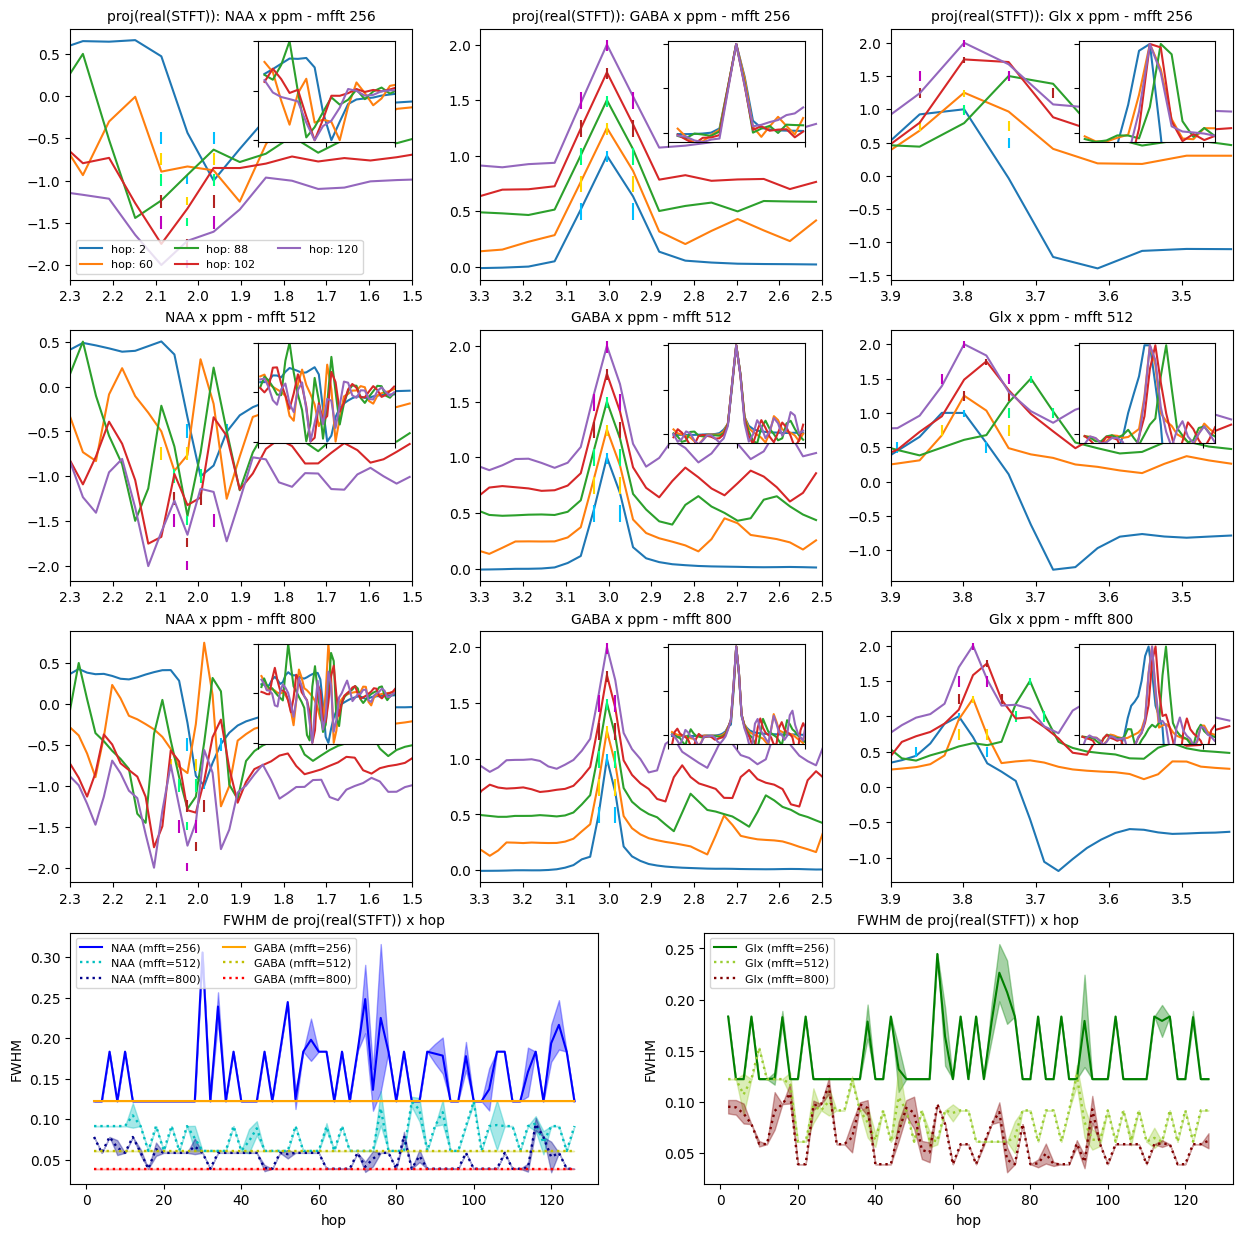

In [31]:
fig = plt.figure(figsize=(15, 15)) 

ax1 = plt.subplot2grid((4, 3), (0, 0))  
ax2 = plt.subplot2grid((4, 3), (0, 1))  
ax3 = plt.subplot2grid((4, 3), (0, 2)) 
ax6 = plt.subplot2grid((4, 3), (1, 0))  
ax7 = plt.subplot2grid((4, 3), (1, 1))  
ax8 = plt.subplot2grid((4, 3), (1, 2)) 
ax9 = plt.subplot2grid((4, 3), (2, 0))  
ax10 = plt.subplot2grid((4, 3), (2, 1))  
ax11 = plt.subplot2grid((4, 3), (2, 2)) 

ax4 = plt.subplot2grid((4, 2), (3, 0)) 
ax5 = plt.subplot2grid((4, 2), (3, 1))

axins1 = ax1.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-1.03,1), xticklabels=[], yticklabels=[])
axins2 = ax2.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins3 = ax3.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins6 = ax6.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-1.03,1), xticklabels=[], yticklabels=[])
axins7 = ax7.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins8 = ax8.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins9 = ax9.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-1.03,1), xticklabels=[], yticklabels=[])
axins10 = ax10.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins11 = ax11.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])


#plot_id = np.arange(0,len(hop_),10)
plot_id = [0,29,43,50,59]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
colors_sec = ['deepskyblue','gold','springgreen','firebrick','m']
for i in range(5):
    aux_256 = np.mean((np.sum(np.real(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][0]),axis=2)),axis=0)
    aux_512 = np.mean((np.sum(np.real(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][0]),axis=2)),axis=0)
    aux_800 = np.mean((np.sum(np.real(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][0]),axis=2)),axis=0)
    aux1d5_256 = utils.give_idx_ppm_point(ppm_array=spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5_256 = utils.give_idx_ppm_point(ppm_array=spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5_256 = utils.give_idx_ppm_point(ppm_array=spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2_256 = utils.give_idx_ppm_point(ppm_array=spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43_256 = utils.give_idx_ppm_point(ppm_array=spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.43)
    aux1d5_512 = utils.give_idx_ppm_point(ppm_array=spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5_512 = utils.give_idx_ppm_point(ppm_array=spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5_512 = utils.give_idx_ppm_point(ppm_array=spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2_512 = utils.give_idx_ppm_point(ppm_array=spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43_512 = utils.give_idx_ppm_point(ppm_array=spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.43)
    aux1d5_800 = utils.give_idx_ppm_point(ppm_array=spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5_800 = utils.give_idx_ppm_point(ppm_array=spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5_800 = utils.give_idx_ppm_point(ppm_array=spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2_800 = utils.give_idx_ppm_point(ppm_array=spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43_800 = utils.give_idx_ppm_point(ppm_array=spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2],ppm_point=3.43)
    ax1.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_256:aux2d5_256],aux_256[aux1d5_256:aux2d5_256]/np.max(np.abs(aux_256[aux1d5_256:aux2d5_256]))-0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax6.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_512:aux2d5_512],aux_512[aux1d5_512:aux2d5_512]/np.max(np.abs(aux_512[aux1d5_512:aux2d5_512]))-0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax9.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_800:aux2d5_800],aux_800[aux1d5_800:aux2d5_800]/np.max(np.abs(aux_800[aux1d5_800:aux2d5_800]))-0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax2.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_256:aux3d5_256],aux_256[aux2d5_256:aux3d5_256]/np.max(aux_256[aux2d5_256:aux3d5_256])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax7.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_512:aux3d5_512],aux_512[aux2d5_512:aux3d5_512]/np.max(aux_512[aux2d5_512:aux3d5_512])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax10.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_800:aux3d5_800],aux_800[aux2d5_800:aux3d5_800]/np.max(aux_800[aux2d5_800:aux3d5_800])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax3.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_256:aux4d2_256],aux_256[aux3d43_256:aux4d2_256]/np.max(aux_256[aux3d43_256:aux4d2_256])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax8.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_512:aux4d2_512],aux_512[aux3d43_512:aux4d2_512]/np.max(aux_512[aux3d43_512:aux4d2_512])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    ax11.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_800:aux4d2_800],aux_800[aux3d43_800:aux4d2_800]/np.max(aux_800[aux3d43_800:aux4d2_800])+0.25*i,label='hop: '+str(hop_[plot_id[i]]),color=colors[i])
    axins1.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_256:aux2d5_256],aux_256[aux1d5_256:aux2d5_256]/np.max(np.abs(aux_256[aux1d5_256:aux2d5_256])), color=colors[i])
    axins6.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_512:aux2d5_512],aux_512[aux1d5_512:aux2d5_512]/np.max(np.abs(aux_512[aux1d5_512:aux2d5_512])), color=colors[i])
    axins9.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux1d5_800:aux2d5_800],aux_800[aux1d5_800:aux2d5_800]/np.max(np.abs(aux_800[aux1d5_800:aux2d5_800])), color=colors[i])
    axins2.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_256:aux3d5_256],aux_256[aux2d5_256:aux3d5_256]/np.max(aux_256[aux2d5_256:aux3d5_256]), color=colors[i])
    axins7.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_512:aux3d5_512],aux_512[aux2d5_512:aux3d5_512]/np.max(aux_512[aux2d5_512:aux3d5_512]), color=colors[i])
    axins10.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux2d5_800:aux3d5_800],aux_800[aux2d5_800:aux3d5_800]/np.max(aux_800[aux2d5_800:aux3d5_800]), color=colors[i])
    axins3.plot(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_256:aux4d2_256],aux_256[aux3d43_256:aux4d2_256]/np.max(aux_256[aux3d43_256:aux4d2_256]), color=colors[i])
    axins8.plot(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_512:aux4d2_512],aux_512[aux3d43_512:aux4d2_512]/np.max(aux_512[aux3d43_512:aux4d2_512]), color=colors[i])
    axins11.plot(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[aux3d43_800:aux4d2_800],aux_800[aux3d43_800:aux4d2_800]/np.max(aux_800[aux3d43_800:aux4d2_800]), color=colors[i])
    aux_NAA = np.mean(idx_fwhm_256['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax1.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],-0.94-0.25*i,-1.04-0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_256['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax2.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_real_256['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax3.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_hop_256['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_NAA = np.mean(idx_fwhm_real_512['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax6.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],-0.94-0.25*i,-1.04-0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_real_512['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax7.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_real_512['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax8.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_hop_512['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_NAA = np.mean(idx_fwhm_real_800['hop_'+str(hop_[plot_id[i]])]['NAA'],axis=0)
    ax9.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[0])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax9.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[1])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax9.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_NAA[2])],-0.94-0.25*i,-1.04-0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_real_800['hop_'+str(hop_[plot_id[i]])]['GABA'],axis=0)
    ax10.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax10.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax10.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_real_800['hop_'+str(hop_[plot_id[i]])]['Glx'],axis=0)
    ax11.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax11.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax11.vlines(np.flip(spgram_hop_800['hop_'+str(hop_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])


ax1.set_xlim(2.3,1.5) 
ax2.set_xlim(3.3,2.5)
ax3.set_xlim(3.9,3.43)  
ax1.legend(loc='lower left', ncols=3,fontsize=8)
ax1.set_title('proj(real(STFT)): NAA x ppm - mfft 256',fontsize = 10)
ax2.set_title('proj(real(STFT)): GABA x ppm - mfft 256',fontsize = 10)
ax3.set_title('proj(real(STFT)): Glx x ppm - mfft 256',fontsize = 10)

ax6.set_xlim(2.3,1.5) 
ax7.set_xlim(3.3,2.5)
ax8.set_xlim(3.9,3.43)  
ax6.set_title('NAA x ppm - mfft 512',fontsize = 10)
ax7.set_title('GABA x ppm - mfft 512',fontsize = 10)
ax8.set_title('Glx x ppm - mfft 512',fontsize = 10)

ax9.set_xlim(2.3,1.5) 
ax10.set_xlim(3.3,2.5)
ax11.set_xlim(3.9,3.43)  
ax9.set_title('NAA x ppm - mfft 800',fontsize = 10)
ax10.set_title('GABA x ppm - mfft 800',fontsize = 10)
ax11.set_title('Glx x ppm - mfft 800',fontsize = 10)


ax4.plot(hop_,metrics_256['fwhm_hop_real']['NAA']['mean'],label='NAA (mfft=256)',color='b')
ax4.fill_between(hop_, np.array(metrics_256['fwhm_hop_real']['NAA']['mean']) - np.array(metrics_256['fwhm_hop_real']['NAA']['std']), 
                        np.array(metrics_256['fwhm_hop_real']['NAA']['mean']) + np.array(metrics_256['fwhm_hop_real']['NAA']['std']), alpha=0.35, color = 'b')
ax4.plot(hop_,metrics_512['fwhm_hop_real']['NAA']['mean'],label='NAA (mfft=512)',color='c',linestyle='dotted',linewidth=1.7)
ax4.fill_between(hop_, np.array(metrics_512['fwhm_hop_real']['NAA']['mean']) - np.array(metrics_512['fwhm_hop_real']['NAA']['std']), 
                        np.array(metrics_512['fwhm_hop_real']['NAA']['mean']) + np.array(metrics_512['fwhm_hop_real']['NAA']['std']), alpha=0.35, color = 'c')
ax4.plot(hop_,metrics_800['fwhm_hop_real']['NAA']['mean'],label='NAA (mfft=800)',color='darkblue',linestyle='dotted',linewidth=1.7)
ax4.fill_between(hop_, np.array(metrics_800['fwhm_hop_real']['NAA']['mean']) - np.array(metrics_800['fwhm_hop_real']['NAA']['std']), 
                        np.array(metrics_800['fwhm_hop_real']['NAA']['mean']) + np.array(metrics_800['fwhm_hop_real']['NAA']['std']), alpha=0.35, color = 'darkblue')
ax4.plot(hop_,metrics_256['fwhm_hop_real']['GABA']['mean'],label='GABA (mfft=256)',color='orange')
ax4.fill_between(hop_, np.array(metrics_256['fwhm_hop_real']['GABA']['mean']) - np.array(metrics_256['fwhm_hop_real']['GABA']['std']), 
                        np.array(metrics_256['fwhm_hop_real']['GABA']['mean']) + np.array(metrics_256['fwhm_hop_real']['GABA']['std']), alpha=0.35, color = 'orange')
ax4.plot(hop_,metrics_512['fwhm_hop_real']['GABA']['mean'],label='GABA (mfft=512)',color='y',linestyle='dotted',linewidth=1.7)
ax4.fill_between(hop_, np.array(metrics_512['fwhm_hop_real']['GABA']['mean']) - np.array(metrics_512['fwhm_hop_real']['GABA']['std']), 
                        np.array(metrics_512['fwhm_hop_real']['GABA']['mean']) + np.array(metrics_512['fwhm_hop_real']['GABA']['std']), alpha=0.35, color = 'y')
ax4.plot(hop_,metrics_800['fwhm_hop_real']['GABA']['mean'],label='GABA (mfft=800)',color='red',linestyle='dotted',linewidth=1.7)
ax4.fill_between(hop_, np.array(metrics_800['fwhm_hop_real']['GABA']['mean']) - np.array(metrics_800['fwhm_hop_real']['GABA']['std']), 
                        np.array(metrics_800['fwhm_hop_real']['GABA']['mean']) + np.array(metrics_800['fwhm_hop_real']['GABA']['std']), alpha=0.35, color = 'red')
ax4.set_title('FWHM de proj(real(STFT)) x hop',fontsize = 10)
ax4.set_xlabel('hop',fontsize = 10)
ax4.set_ylabel('FWHM',fontsize = 10)
ax4.legend(loc='upper left', ncols = 2, fontsize=8)
ax5.plot(hop_,metrics_256['fwhm_hop_real']['Glx']['mean'],label='Glx (mfft=256)',color='g')
ax5.fill_between(hop_, np.array(metrics_256['fwhm_hop_real']['Glx']['mean']) - np.array(metrics_256['fwhm_hop_real']['Glx']['std']), 
                    np.array(metrics_256['fwhm_hop_real']['Glx']['mean']) + np.array(metrics_256['fwhm_hop_real']['Glx']['std']), alpha=0.35, color = 'g')
ax5.plot(hop_,metrics_512['fwhm_hop_real']['Glx']['mean'],label='Glx (mfft=512)',color='yellowgreen',linestyle='dotted',linewidth=1.7)
ax5.fill_between(hop_, np.array(metrics_512['fwhm_hop_real']['Glx']['mean']) - np.array(metrics_512['fwhm_hop_real']['Glx']['std']), 
                    np.array(metrics_512['fwhm_hop_real']['Glx']['mean']) + np.array(metrics_512['fwhm_hop_real']['Glx']['std']), alpha=0.35, color = 'yellowgreen')
ax5.plot(hop_,metrics_800['fwhm_hop_real']['Glx']['mean'],label='Glx (mfft=800)',color='maroon',linestyle='dotted',linewidth=1.7)
ax5.fill_between(hop_, np.array(metrics_800['fwhm_hop_real']['Glx']['mean']) - np.array(metrics_800['fwhm_hop_real']['Glx']['std']), 
                    np.array(metrics_800['fwhm_hop_real']['Glx']['mean']) + np.array(metrics_800['fwhm_hop_real']['Glx']['std']), alpha=0.35, color = 'maroon')
ax5.set_title('FWHM de proj(real(STFT)) x hop',fontsize = 10)
ax5.set_xlabel('hop',fontsize = 10)
ax5.set_ylabel('FWHM',fontsize = 10)
ax5.legend(loc='upper left', fontsize=8)

if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_fwhm_real.png')

O padrão de listras das imagens muda com hop?

A variação do ZCR com o hop parece coincidir para os trÊs valores de mfft observados. As diferenças observadas nos valores medidos para o ZCR podem ser justificadas pela diferente precisão na escolha das linhas mais próximas de 2,02 ppm, 3 ppm e 3,75 ppm. Pelas imagens observadas fica claro que a quantidade de listras para o NAA é determinada apenas pelo hop e independente do valor de mfft. Para o Glx, como esse pico é distribuído em duas frequências, a menor resolução com mfft=256 interfere na identificação visual da quantidade de listras. 

As medições de ZCR obtidas para mfft=256 e mfft=512 se coincidem em mais valores de hops do que as medições para mfft=800, que apresenta diferentes intesidades e parece levemente deslocada para o Glx. Além de duas medições para o GABA indicarem ZCR nulo.

In [16]:
aux_concat = (np.arange(11,20)).tolist()
spgram_hop_concat_for_zcr_256 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_256,list_time_idx=idx_time_0d4_256,fid_idx_plot=0)
spgram_hop_concat_for_zcr_512 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_512,list_time_idx=idx_time_0d4_512,fid_idx_plot=0)
spgram_hop_concat_for_zcr_800 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop_800,list_time_idx=idx_time_0d4_800,fid_idx_plot=0)
#aux_concat = (np.arange(3,12)).tolist()

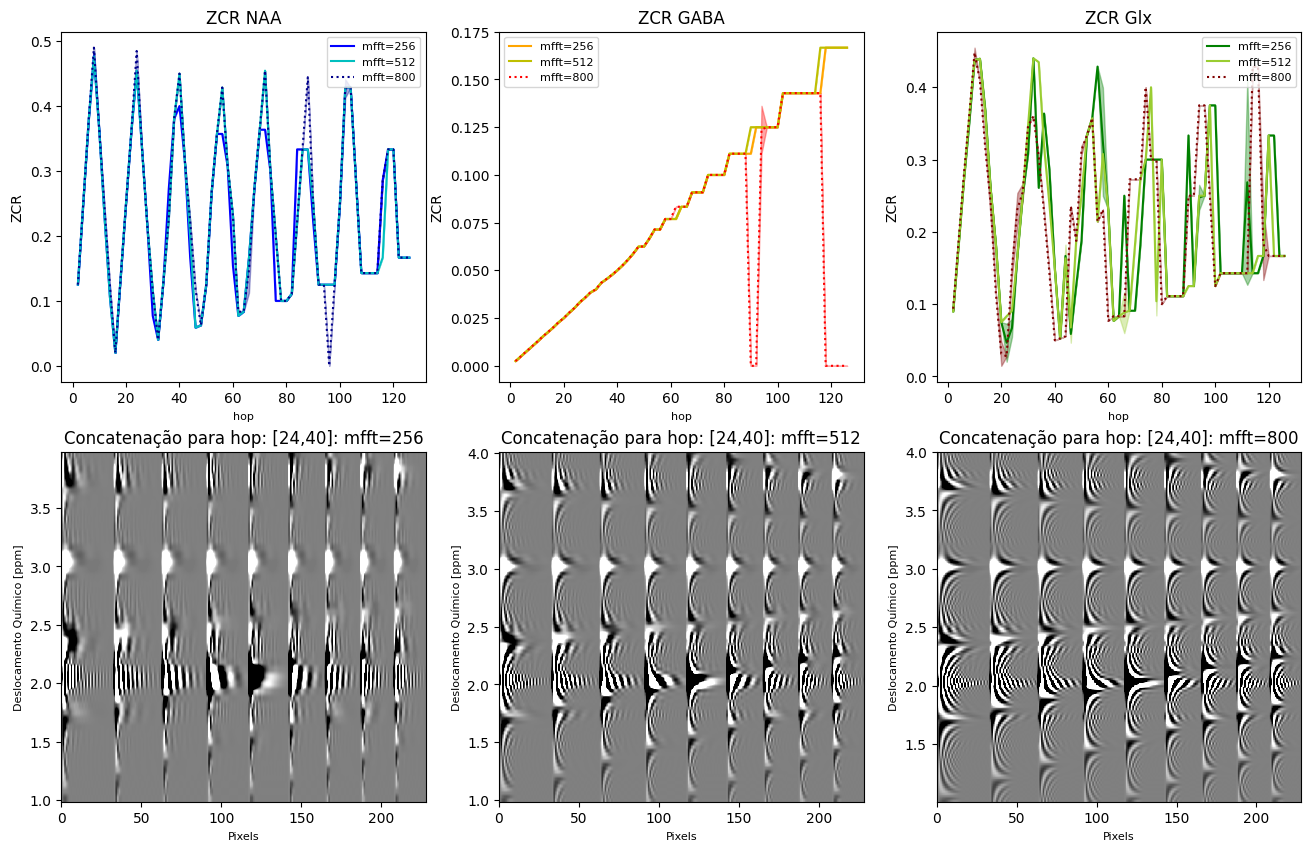

In [18]:
fig,ax = plt.subplots(2,3,figsize=(16,10))

ax.flat[0].plot(hop_,metrics_256['zcr_']['NAA']['mean'],color='b',label='mfft=256')
ax.flat[0].fill_between(hop_, np.array(metrics_256['zcr_']['NAA']['mean']) - np.array(metrics_256['zcr_']['NAA']['std']), 
                        np.array(metrics_256['zcr_']['NAA']['mean']) + np.array(metrics_256['zcr_']['NAA']['std']), alpha=0.35, color = 'b')
ax.flat[0].plot(hop_,metrics_512['zcr_']['NAA']['mean'],color='c',label='mfft=512')
ax.flat[0].fill_between(hop_, np.array(metrics_512['zcr_']['NAA']['mean']) - np.array(metrics_512['zcr_']['NAA']['std']), 
                        np.array(metrics_512['zcr_']['NAA']['mean']) + np.array(metrics_512['zcr_']['NAA']['std']), alpha=0.35, color = 'c')
ax.flat[0].plot(hop_,metrics_800['zcr_']['NAA']['mean'],color='darkblue',linestyle='dotted',label='mfft=800')
ax.flat[0].fill_between(hop_, np.array(metrics_800['zcr_']['NAA']['mean']) - np.array(metrics_800['zcr_']['NAA']['std']), 
                        np.array(metrics_800['zcr_']['NAA']['mean']) + np.array(metrics_800['zcr_']['NAA']['std']), alpha=0.35, color = 'darkblue')
ax.flat[0].set_title('ZCR NAA')
ax.flat[0].set_ylabel('ZCR')
ax.flat[0].set_xlabel('hop',fontsize=8)
ax.flat[0].legend(loc='upper right', fontsize=8)

ax.flat[1].plot(hop_,metrics_256['zcr_']['GABA']['mean'],color='orange',label='mfft=256')
ax.flat[1].fill_between(hop_, np.array(metrics_256['zcr_']['GABA']['mean']) - np.array(metrics_256['zcr_']['GABA']['std']), 
                        np.array(metrics_256['zcr_']['GABA']['mean']) + np.array(metrics_256['zcr_']['GABA']['std']), alpha=0.35, color = 'orange')
ax.flat[1].plot(hop_,metrics_512['zcr_']['GABA']['mean'],color='y',label='mfft=512')
ax.flat[1].fill_between(hop_, np.array(metrics_512['zcr_']['GABA']['mean']) - np.array(metrics_512['zcr_']['GABA']['std']), 
                        np.array(metrics_512['zcr_']['GABA']['mean']) + np.array(metrics_512['zcr_']['GABA']['std']), alpha=0.35, color = 'y')
ax.flat[1].plot(hop_,metrics_800['zcr_']['GABA']['mean'],color='red',linestyle='dotted',label='mfft=800')
ax.flat[1].fill_between(hop_, np.array(metrics_800['zcr_']['GABA']['mean']) - np.array(metrics_800['zcr_']['GABA']['std']), 
                        np.array(metrics_800['zcr_']['GABA']['mean']) + np.array(metrics_800['zcr_']['GABA']['std']), alpha=0.35, color = 'red')
ax.flat[1].set_title('ZCR GABA')
ax.flat[1].set_ylabel('ZCR')
ax.flat[1].set_xlabel('hop',fontsize=8)
ax.flat[1].legend(loc='upper left', fontsize=8)

ax.flat[2].plot(hop_,metrics_256['zcr_']['Glx']['mean'],color='g',label='mfft=256')
ax.flat[2].fill_between(hop_, np.array(metrics_256['zcr_']['Glx']['mean']) - np.array(metrics_256['zcr_']['Glx']['std']), 
                        np.array(metrics_256['zcr_']['Glx']['mean']) + np.array(metrics_256['zcr_']['Glx']['std']), alpha=0.35, color = 'g')
ax.flat[2].plot(hop_,metrics_512['zcr_']['Glx']['mean'],color='yellowgreen',label='mfft=512')
ax.flat[2].fill_between(hop_, np.array(metrics_512['zcr_']['Glx']['mean']) - np.array(metrics_512['zcr_']['Glx']['std']), 
                        np.array(metrics_512['zcr_']['Glx']['mean']) + np.array(metrics_512['zcr_']['Glx']['std']), alpha=0.35, color = 'yellowgreen')
ax.flat[2].plot(hop_,metrics_800['zcr_']['Glx']['mean'],color='maroon',linestyle='dotted',label='mfft=800')
ax.flat[2].fill_between(hop_, np.array(metrics_800['zcr_']['Glx']['mean']) - np.array(metrics_800['zcr_']['Glx']['std']), 
                        np.array(metrics_800['zcr_']['Glx']['mean']) + np.array(metrics_800['zcr_']['Glx']['std']), alpha=0.35, color = 'maroon')
ax.flat[2].set_title('ZCR Glx')
ax.flat[2].set_ylabel('ZCR')
ax.flat[2].set_xlabel('hop',fontsize=8)
ax.flat[2].legend(loc='upper right', fontsize=8)

ax.flat[3].imshow(np.real(spgram_hop_concat_for_zcr_256[idx_freq_1ppm_256[0]:idx_freq_4ppm_256[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_for_zcr_256.shape[-1],np.flip(spgram_hop_256['hop_'+str(hop_[0])][2])[idx_freq_1ppm_256[0]],np.flip(spgram_hop_256['hop_'+str(hop_[0])][2])[idx_freq_4ppm_256[0]]))
ax.flat[3].set_xlabel('Pixels', fontsize=8)
ax.flat[3].set_ylabel('Deslocamento Químico [ppm]', fontsize=8)
ax.flat[3].set_title('Concatenação para hop: [24,40]: mfft=256')
ax.flat[4].imshow(np.real(spgram_hop_concat_for_zcr_512[idx_freq_1ppm_512[0]:idx_freq_4ppm_512[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_for_zcr_512.shape[-1],np.flip(spgram_hop_512['hop_'+str(hop_[0])][2])[idx_freq_1ppm_512[0]],np.flip(spgram_hop_512['hop_'+str(hop_[0])][2])[idx_freq_4ppm_512[0]]))
ax.flat[4].set_xlabel('Pixels', fontsize=8)
ax.flat[4].set_ylabel('Deslocamento Químico [ppm]', fontsize=8)
ax.flat[4].set_title('Concatenação para hop: [24,40]: mfft=512')
ax.flat[5].imshow(np.real(spgram_hop_concat_for_zcr_800[idx_freq_1ppm_800[0]:idx_freq_4ppm_800[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat_for_zcr_800.shape[-1],np.flip(spgram_hop_800['hop_'+str(hop_[0])][2])[idx_freq_1ppm_800[0]],np.flip(spgram_hop_800['hop_'+str(hop_[0])][2])[idx_freq_4ppm_800[0]]))
ax.flat[5].set_xlabel('Pixels', fontsize=8)
ax.flat[5].set_ylabel('Deslocamento Químico [ppm]', fontsize=8)
ax.flat[5].set_title('Concatenação para hop: [24,40]: mfft=800')

if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_zcr.png')

Estudo do valor máximo das seções:

As seções: -4:1 ppm, 6:7, 8.5:9 e 9:10 ppm apresentam o mesmo comportamento: para menores hops, o valor máximo é maior para mfft=256 e menor para mfft=800. Conforme o hop aumenta, as curvas de mfft=256 diminuem com mais suavidade do que para os demais valores de mfft, nos quais nota-se um decaimento abrupto para hop=60. 

Nas seções 1:1.5 e 5:6 que foram agrupadas juntas por questões de intensidade, o comportamento dos valores máximos com o hop é, no geral, semelhante para os três valores de mfft, sendo as curvas para mfft=512 e 800 mais próximas entre si.

Seções: 3.5:4, 2.5:3.5 e 7:8.5: os picos de GABA e Glx são mais intensos para mfft=256 e decrescem com mfft. O pico em 7:8.5 ppm varia mais intensamente para mfft=256. 

O comportamento daos valores máximos nas seções 7:8.5, 4:5 e 1.5:2.5 é parecido para os diferentes valores de mfft: mfft=256 varia mais intensamente e mfft=512 e 800 são mais próximos.

Na região residual, os redíduos são mais intensos para mfft=800 e decaem com mfft (provavelemente relacionado com os picos demorarem mais para decair). Para todas as curvas, o resíduo cresce com o hop.

Apesar de variações em intensidade e velocidade de variação, as tendências dos valores máximos com o hop são as mesmas para os três mffts testados. E não muda-se os valores estabelecidos para segmentação da imagem.

- |x| < 0,001 (região de resíduo)
- 0,001 < |x| < 0,02 (região dos picos fantasmas)
- 0,02 < |x| < 0,08 (região em torno dos picos)
- 0,08 < |x| < 0,2 (região de alguns picos relevantes)
- 0,2 < |x| < 0,6 (região do pico entre 4 e 5 ppm)
- |x| > 0,6 (região do pico de NAA)

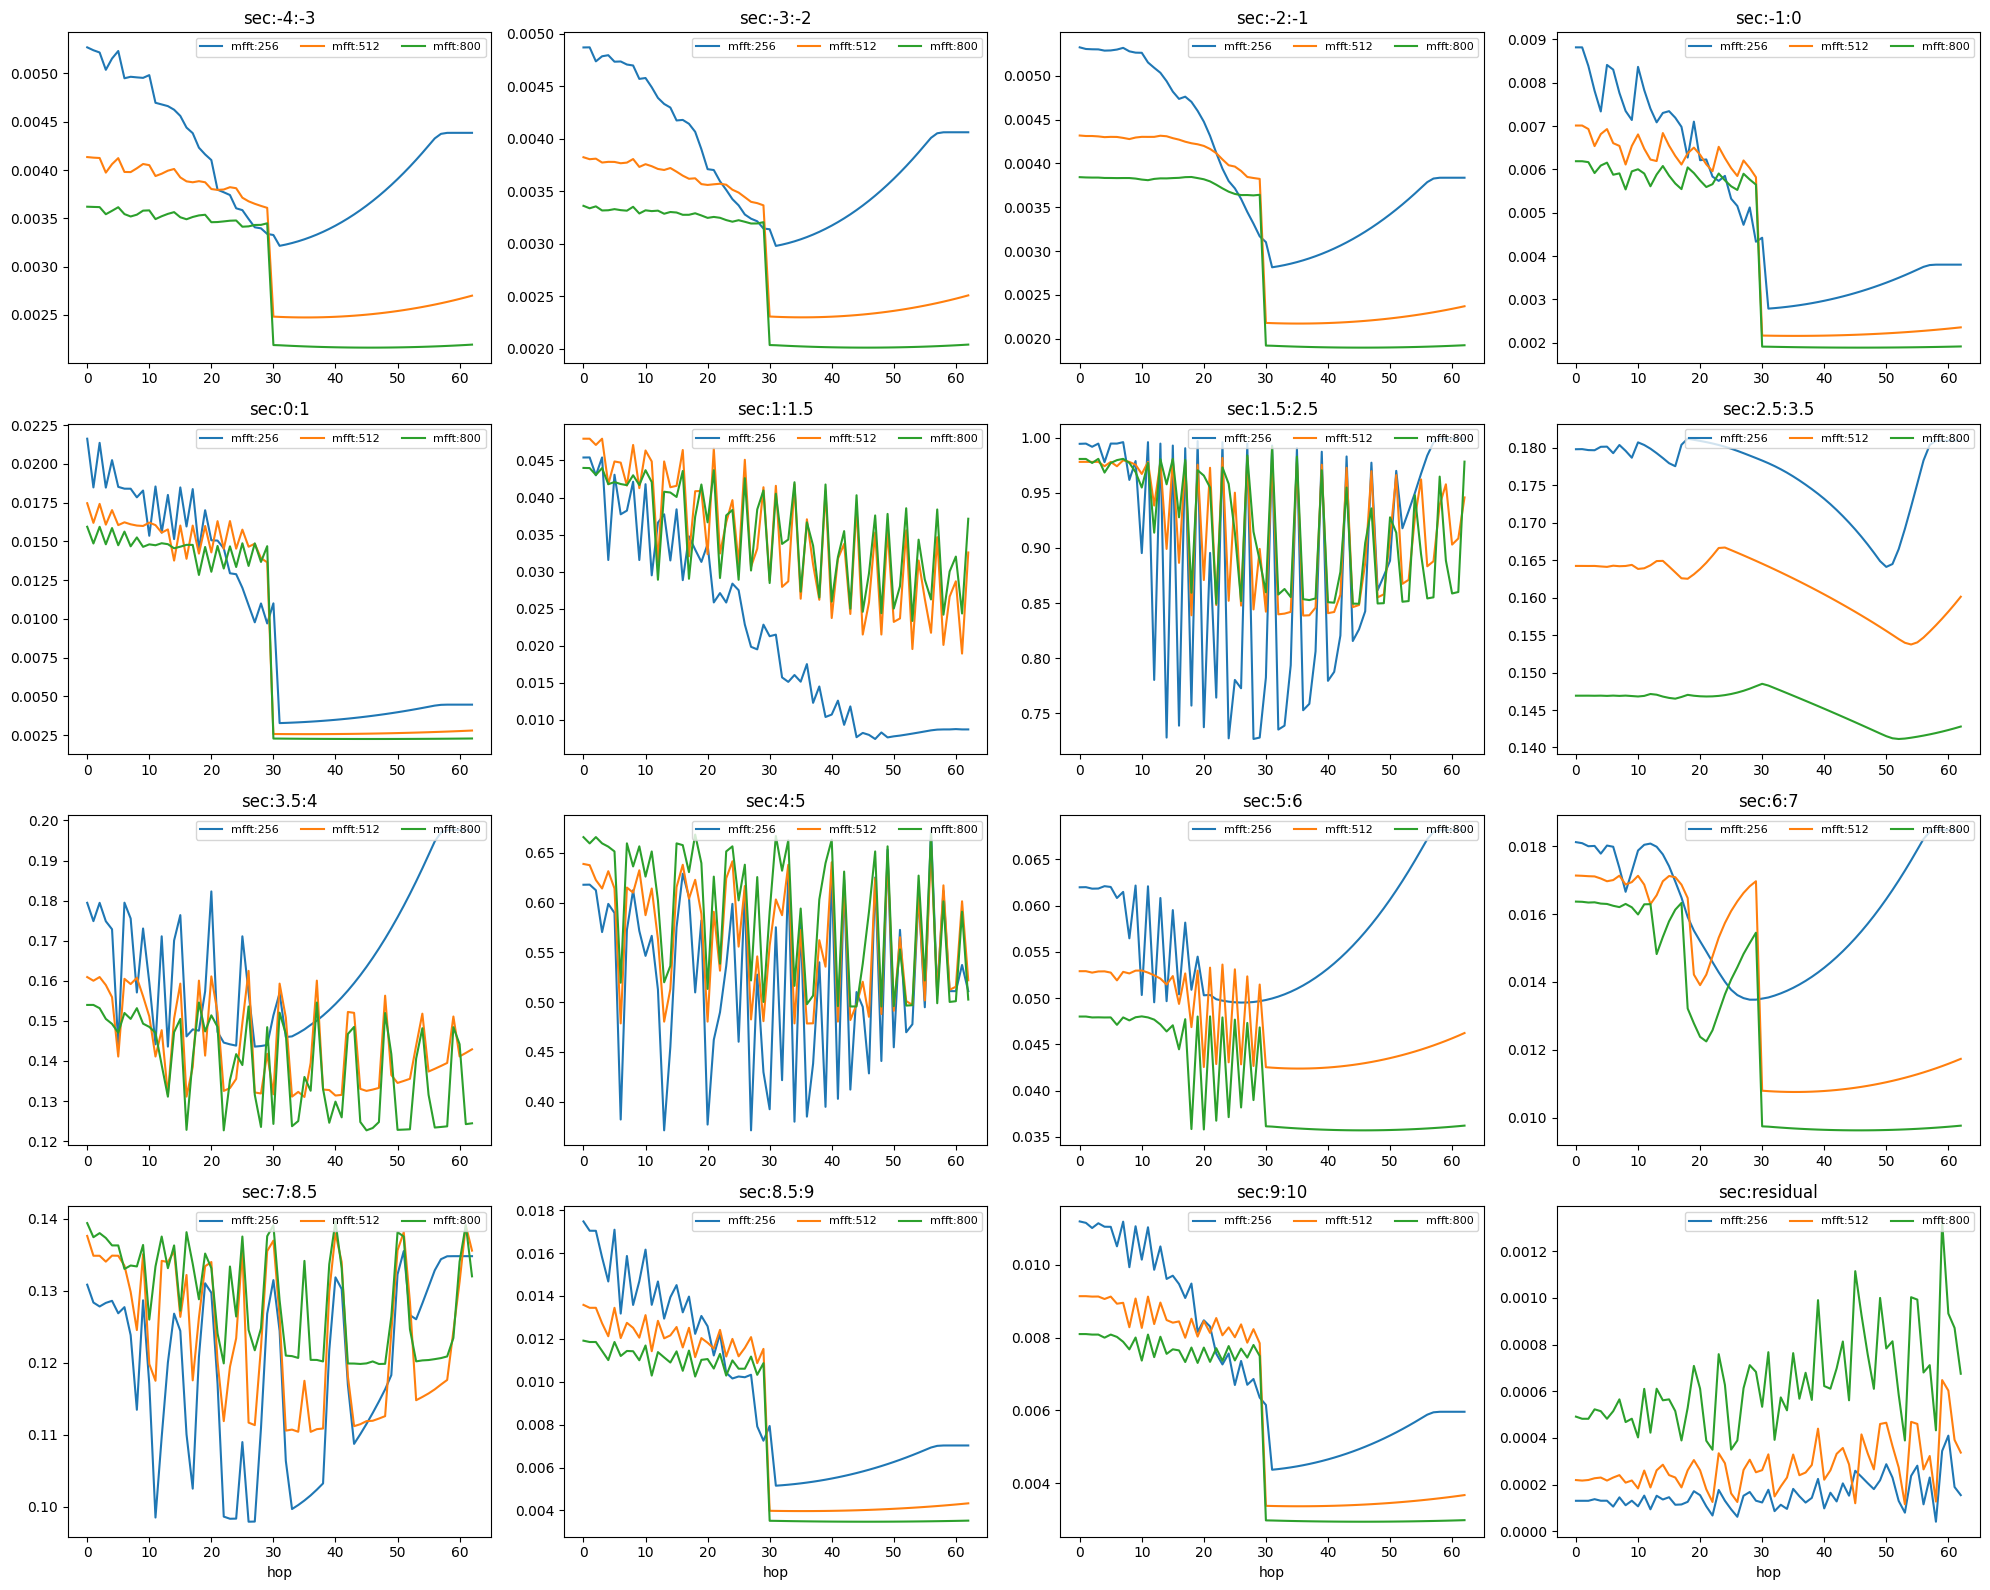

In [41]:
fig, ax = plt.subplots(4,4,figsize=(20,16))
sec_list = list(metrics_256['max_sec'].keys())
for i in range(len(sec_list)):
    ax.flat[i].plot(metrics_256['max_sec'][sec_list[i]]['mean'],label='mfft:256')
    ax.flat[i].plot(metrics_512['max_sec'][sec_list[i]]['mean'],label='mfft:512')
    ax.flat[i].plot(metrics_800['max_sec'][sec_list[i]]['mean'],label='mfft:800')
    ax.flat[i].set_title('sec:' + sec_list[i])
    ax.flat[i].legend(loc = 'upper right', ncols = 3, fontsize = 8)
    if i >= 12:
        ax.flat[i].set_xlabel('hop')
plt.tight_layout()

if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_sections_max.png')

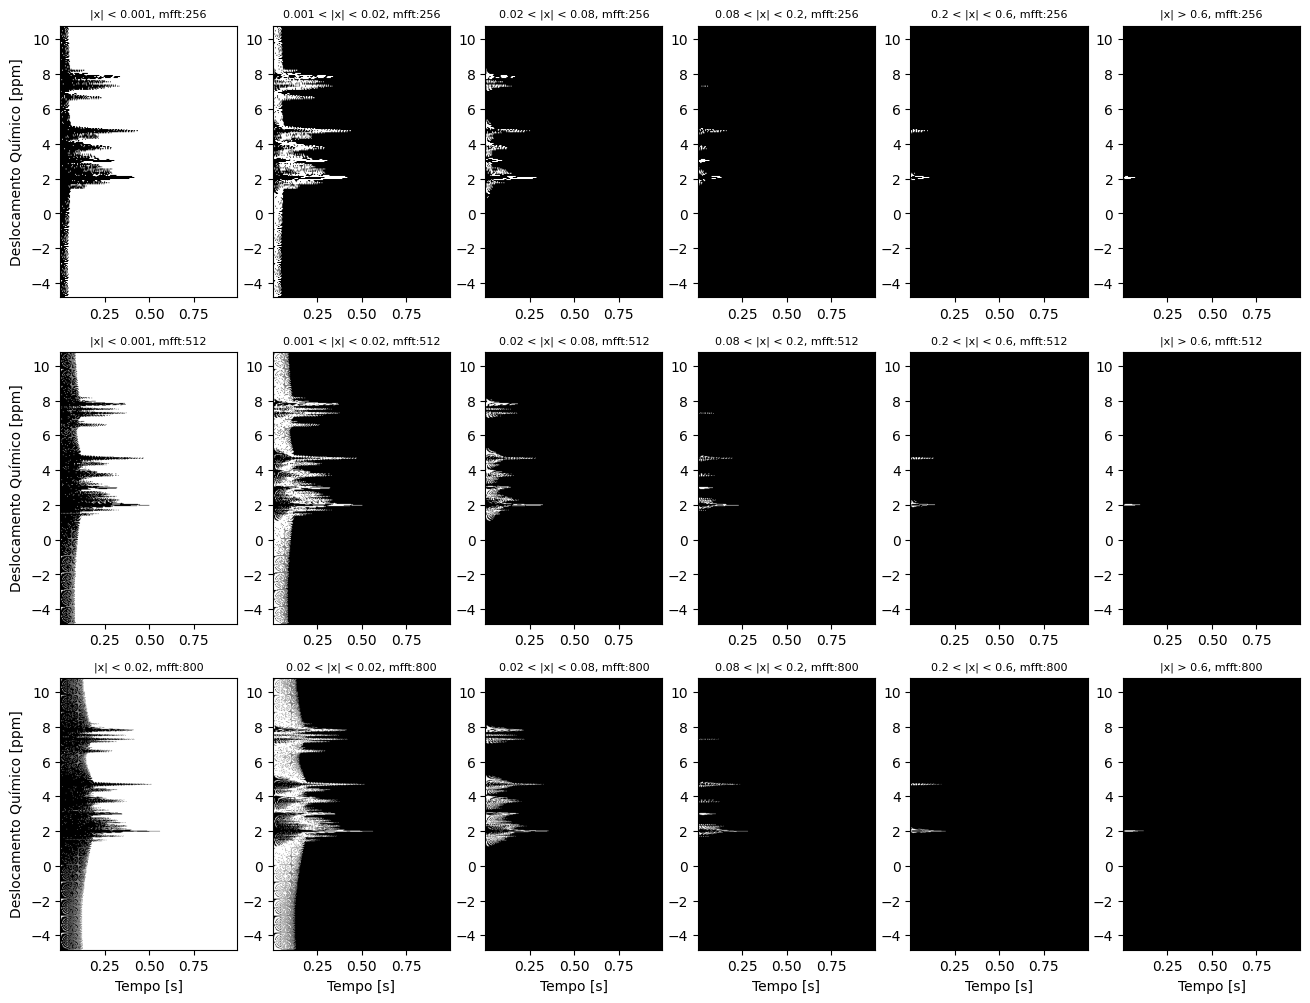

In [20]:
fig,ax = plt.subplots(3,6,figsize=(16,12))
hop_id = 3
row = 0

seg_res = (np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.001).astype('int')
seg_res2 = (np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.001).astype('int')*(np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.02).astype('int')
seg_res3 = (np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.08).astype('int')
seg_res4 = (np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.2).astype('int')
seg_res5 = (np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.6).astype('int')
seg_res6 = (np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.6).astype('int')*(np.abs(np.real(spgram_hop_256['hop_'+str(hop_[hop_id])][0][0,:,:])) < 1).astype('int')
    

ax.flat[0].imshow(seg_res,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_256['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_256['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[1].imshow(seg_res2,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_256['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_256['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[2].imshow(seg_res3,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_256['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_256['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[3].imshow(seg_res4,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_256['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_256['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[4].imshow(seg_res5,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_256['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_256['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[5].imshow(seg_res6,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_256['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_256['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_256['hop_'+str(hop_[hop_id])][2])[-1]))

seg_res = (np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.001).astype('int')
seg_res2 = (np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.001).astype('int')*(np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.02).astype('int')
seg_res3 = (np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.08).astype('int')
seg_res4 = (np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.2).astype('int')
seg_res5 = (np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.6).astype('int')
seg_res6 = (np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.6).astype('int')*(np.abs(np.real(spgram_hop_512['hop_'+str(hop_[hop_id])][0][0,:,:])) < 1).astype('int')
    

ax.flat[6+0].imshow(seg_res,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_512['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_512['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[6+1].imshow(seg_res2,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_512['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_512['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[6+2].imshow(seg_res3,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_512['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_512['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[6+3].imshow(seg_res4,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_512['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_512['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[6+4].imshow(seg_res5,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_512['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_512['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[6+5].imshow(seg_res6,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_512['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_512['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_512['hop_'+str(hop_[hop_id])][2])[-1]))

seg_res = (np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.001).astype('int')
seg_res2 = (np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.001).astype('int')*(np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.02).astype('int')
seg_res3 = (np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.08).astype('int')
seg_res4 = (np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.2).astype('int')
seg_res5 = (np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) < 0.6).astype('int')
seg_res6 = (np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) > 0.6).astype('int')*(np.abs(np.real(spgram_hop_800['hop_'+str(hop_[hop_id])][0][0,:,:])) < 1).astype('int')
    

ax.flat[12+0].imshow(seg_res,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_800['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_800['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[12+1].imshow(seg_res2,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_800['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_800['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[12+2].imshow(seg_res3,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_800['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_800['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[12+3].imshow(seg_res4,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_800['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_800['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[12+4].imshow(seg_res5,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_800['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_800['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[-1]))
ax.flat[12+5].imshow(seg_res6,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop_800['hop_'+str(hop_[hop_id])][-1][0],spgram_hop_800['hop_'+str(hop_[hop_id])][-1][-1],
                    np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[0],np.flip(spgram_hop_800['hop_'+str(hop_[hop_id])][2])[-1]))


ax.flat[0].set_title('|x| < 0.001, mfft:256',fontsize=8)
ax.flat[1].set_title('0.001 < |x| < 0.02, mfft:256',fontsize=8)
ax.flat[2].set_title('0.02 < |x| < 0.08, mfft:256',fontsize=8)
ax.flat[3].set_title('0.08 < |x| < 0.2, mfft:256',fontsize=8)
ax.flat[4].set_title('0.2 < |x| < 0.6, mfft:256',fontsize=8)
ax.flat[5].set_title('|x| > 0.6, mfft:256',fontsize=8)
ax.flat[6+0].set_title('|x| < 0.001, mfft:512',fontsize=8)
ax.flat[6+1].set_title('0.001 < |x| < 0.02, mfft:512',fontsize=8)
ax.flat[6+2].set_title('0.02 < |x| < 0.08, mfft:512',fontsize=8)
ax.flat[6+3].set_title('0.08 < |x| < 0.2, mfft:512',fontsize=8)
ax.flat[6+4].set_title('0.2 < |x| < 0.6, mfft:512',fontsize=8)
ax.flat[6+5].set_title('|x| > 0.6, mfft:512',fontsize=8)
ax.flat[12+0].set_title('|x| < 0.02, mfft:800',fontsize=8)
ax.flat[12+1].set_title('0.02 < |x| < 0.02, mfft:800',fontsize=8)
ax.flat[12+2].set_title('0.02 < |x| < 0.08, mfft:800',fontsize=8)
ax.flat[12+3].set_title('0.08 < |x| < 0.2, mfft:800',fontsize=8)
ax.flat[12+4].set_title('0.2 < |x| < 0.6, mfft:800',fontsize=8)
ax.flat[12+5].set_title('|x| > 0.6, mfft:800',fontsize=8)
ax.flat[0].set_ylabel('Deslocamento Químico [ppm]')
ax.flat[6].set_ylabel('Deslocamento Químico [ppm]')
ax.flat[12].set_ylabel('Deslocamento Químico [ppm]')
for i in range(6):
    ax.flat[12+i].set_xlabel('Tempo [s]')

if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_segmented_regions.png')

Apesar das tendências de variação da porcentagem de pixels em cada região em fundção do hop serem as mesmas para os três valores de mfft, nas regiões de ruído, de picos fantasmas e o contorno mais externo dos picos nota-se diferenças nas proporções entre cada valor de mfft. Isso é devido a diferença na extensão dos picos, que cresce com mfft, assim, a região de ruído é com menor porcentagem para mfft=800, e para mfft=800 as duas outras regiões tem um percentual maior que para os demais valores de mfft.

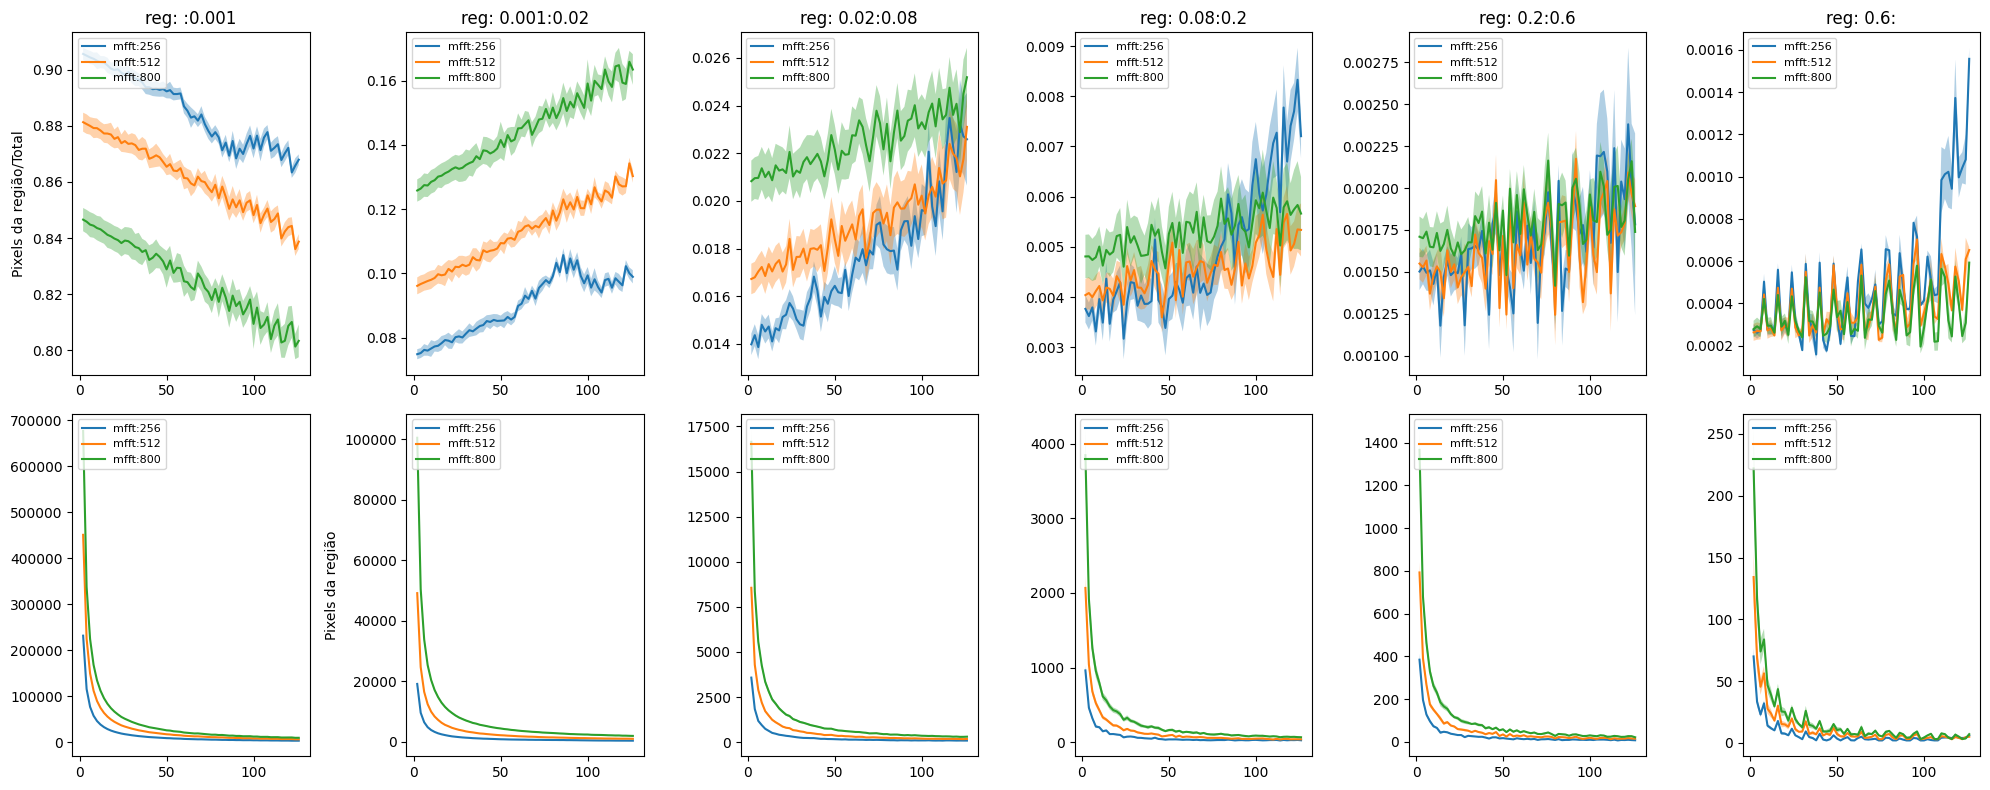

In [42]:
#colors = ['orchid','chocolate','chartreuse','brown','tomato','turquoise']
fig,ax = plt.subplots(2,6,figsize=(20,8))
for i in range(len(list(metrics_256['qntty_percent_regions'].keys()))):
    aux = np.array(metrics_256['qntty_percent_regions'][list(metrics_256['qntty_percent_regions'].keys())[i]]['mean'])
    aux_std = np.array(metrics_256['qntty_percent_regions'][list(metrics_256['qntty_percent_regions'].keys())[i]]['std'])
    ax.flat[i].plot(hop_,aux,label='mfft:256')
    ax.flat[i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    aux = np.array(metrics_512['qntty_percent_regions'][list(metrics_512['qntty_percent_regions'].keys())[i]]['mean'])
    aux_std = np.array(metrics_512['qntty_percent_regions'][list(metrics_512['qntty_percent_regions'].keys())[i]]['std'])
    ax.flat[i].plot(hop_,aux,label='mfft:512')
    ax.flat[i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    aux = np.array(metrics_800['qntty_percent_regions'][list(metrics_800['qntty_percent_regions'].keys())[i]]['mean'])
    aux_std = np.array(metrics_800['qntty_percent_regions'][list(metrics_800['qntty_percent_regions'].keys())[i]]['std'])
    ax.flat[i].plot(hop_,aux,label='mfft:800')
    ax.flat[i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    
    ax.flat[i].set_title('reg: '+list(metrics_800['qntty_percent_regions'].keys())[i])  
    ax.flat[i].legend(loc='upper left',fontsize=8)
    aux = np.array(metrics_256['qntty_absolute_regions'][list(metrics_256['qntty_absolute_regions'].keys())[i]]['mean'])
    aux_std = np.array(metrics_256['qntty_absolute_regions'][list(metrics_256['qntty_absolute_regions'].keys())[i]]['std'])
    ax.flat[6+i].plot(hop_,aux,label='mfft:256')
    ax.flat[6+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    aux = np.array(metrics_512['qntty_absolute_regions'][list(metrics_512['qntty_absolute_regions'].keys())[i]]['mean'])
    aux_std = np.array(metrics_512['qntty_absolute_regions'][list(metrics_512['qntty_absolute_regions'].keys())[i]]['std'])
    ax.flat[6+i].plot(hop_,aux,label='mfft:512')
    ax.flat[6+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    aux = np.array(metrics_800['qntty_absolute_regions'][list(metrics_800['qntty_absolute_regions'].keys())[i]]['mean'])
    aux_std = np.array(metrics_800['qntty_absolute_regions'][list(metrics_800['qntty_absolute_regions'].keys())[i]]['std'])
    ax.flat[6+i].plot(hop_,aux,label='mfft:800')
    ax.flat[6+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    ax.flat[6+i].legend(loc='upper left',fontsize=8)
ax.flat[0].set_ylabel('Pixels da região/Total')
ax.flat[7].set_ylabel('Pixels da região')
plt.tight_layout()
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_qntty_per_region.png')

A maioria das estatísticas se confunde para os três valores de mfft. Indicando que a distribuição dos valores na imagem muda mais com o hop do que com o valor de mfft. 

Algumas métricas se diferenciam para diferentes valores de mfft. Notamente, o desvio padrão e a kurtosis da região de ruído: havia sido notado que a região de ruído tinha valores máximos maiores para mfft=800, e o desvio padrão nesse caso também é maior. Cosnequentemente, tem-se a menor kurtosis para mfft=800.  Já a média e mediana na região dos picos fantasmas é maior para mfft=256 e menor para mfft=800, indicando a maior presença de valores positivos para mfft=256 nessa região.

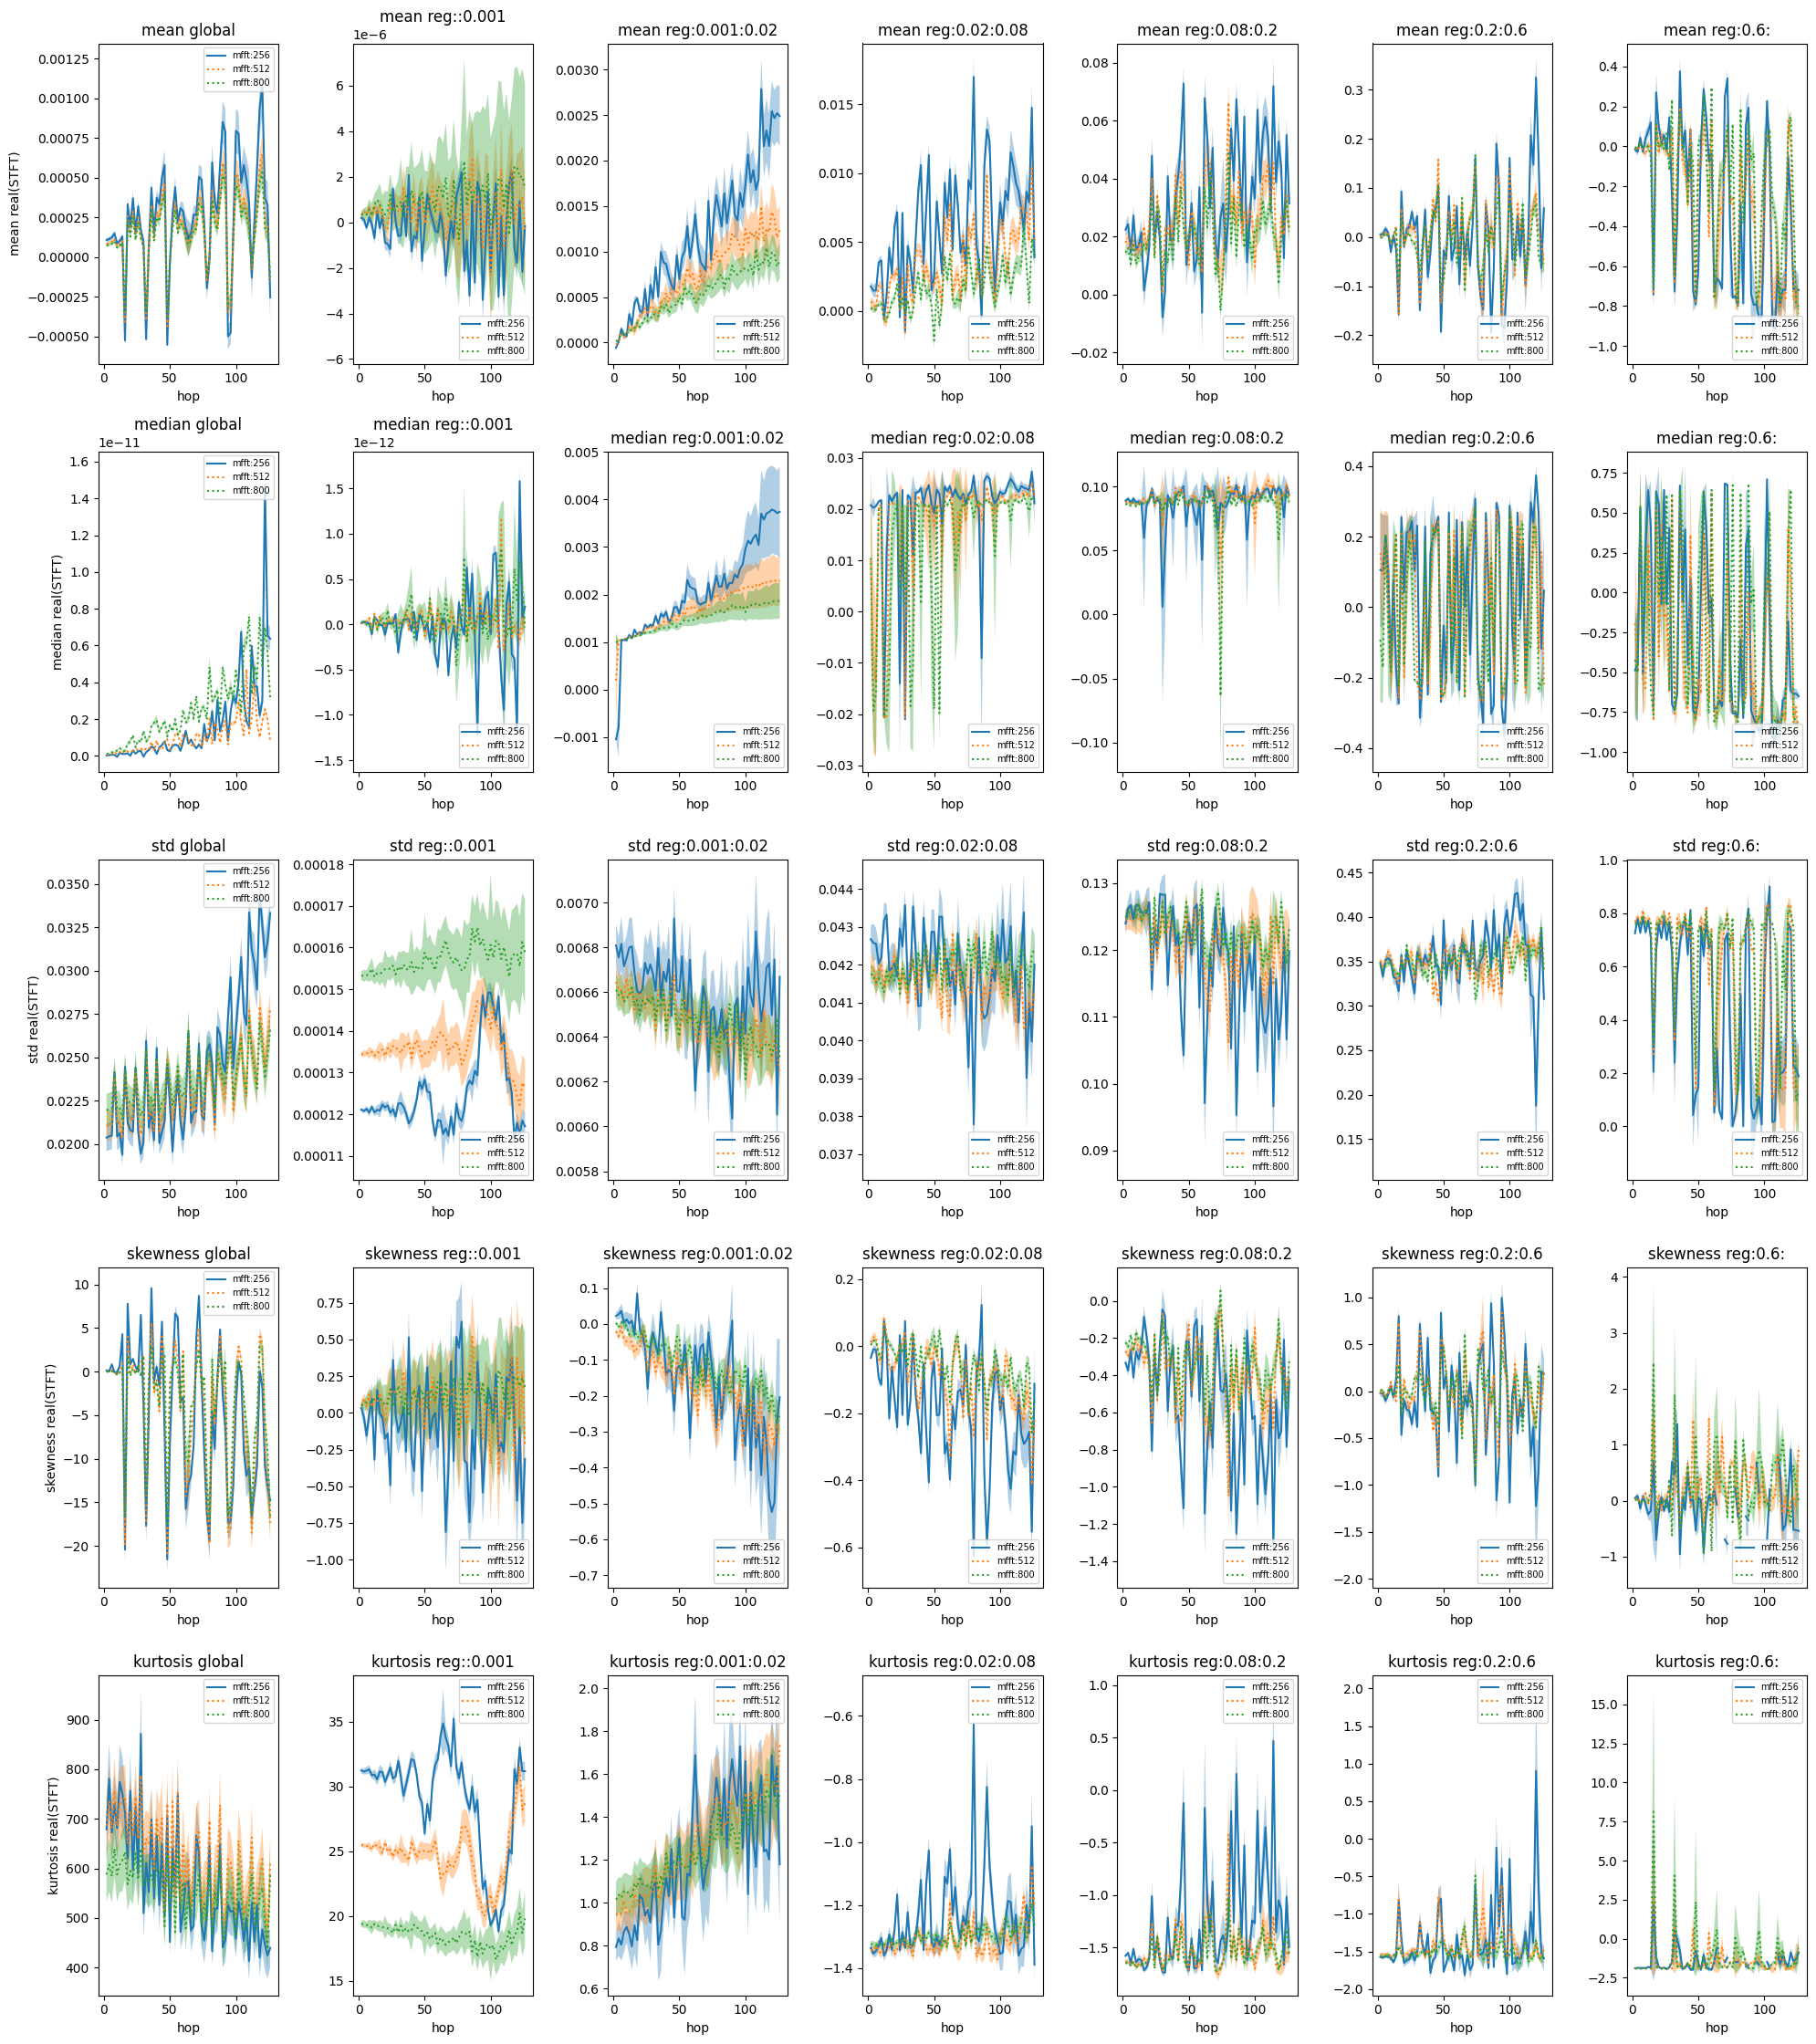

In [43]:
stat_name_list = list(metrics_256['stats_global'].keys())
sec_list = list(metrics_256['stats_per_region'][stat_name].keys())

fig,ax = plt.subplots(len(stat_name_list),7,figsize=(20,4.5*len(stat_name_list)))
for idx_stat, stat_name in enumerate(stat_name_list):
    aux = np.array(metrics_256['stats_global'][stat_name]['mean'])
    aux_std = np.array(metrics_256['stats_global'][stat_name]['std'])
    ax.flat[7*idx_stat].plot(hop_,aux,label='mfft:256')
    ax.flat[7*idx_stat].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    aux = np.array(metrics_512['stats_global'][stat_name]['mean'])
    aux_std = np.array(metrics_512['stats_global'][stat_name]['std'])
    ax.flat[7*idx_stat].plot(hop_,aux,label='mfft:512',linestyle='dotted')
    ax.flat[7*idx_stat].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    aux = np.array(metrics_800['stats_global'][stat_name]['mean'])
    aux_std = np.array(metrics_800['stats_global'][stat_name]['std'])
    ax.flat[7*idx_stat].plot(hop_,aux,label='mfft:800',linestyle='dotted')
    ax.flat[7*idx_stat].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    ax.flat[7*idx_stat].set_title(stat_name+' global')
    ax.flat[7*idx_stat].legend(loc='upper right', fontsize=7)
    ax.flat[7*idx_stat].set_xlabel('hop')
    ax.flat[7*idx_stat].set_ylabel(stat_name+' real(STFT)')

    for i in range(1,6):
        aux = np.array(metrics_256['stats_per_region'][stat_name][sec_list[i-1]]['mean'])
        aux_std = np.array(metrics_256['stats_per_region'][stat_name][sec_list[i-1]]['std'])
        ax.flat[7*idx_stat+i].plot(hop_,aux,label='mfft:256')
        ax.flat[7*idx_stat+i].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35)
        aux = np.array(metrics_512['stats_per_region'][stat_name][sec_list[i-1]]['mean'])
        aux_std = np.array(metrics_512['stats_per_region'][stat_name][sec_list[i-1]]['std'])
        ax.flat[7*idx_stat+i].plot(hop_,aux,label='mfft:512',linestyle='dotted')
        ax.flat[7*idx_stat+i].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35)
        aux = np.array(metrics_800['stats_per_region'][stat_name][sec_list[i-1]]['mean'])
        aux_std = np.array(metrics_800['stats_per_region'][stat_name][sec_list[i-1]]['std'])
        ax.flat[7*idx_stat+i].plot(hop_,aux,label='mfft:800',linestyle='dotted')
        ax.flat[7*idx_stat+i].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35)
        ax.flat[7*idx_stat+i].set_title(stat_name+' reg:'+sec_list[i-1])
        if idx_stat == 4:
            ax.flat[7*idx_stat+i].legend(loc='upper right', fontsize=7)
        else:
            ax.flat[7*idx_stat+i].legend(loc='lower right', fontsize=7)
        ax.flat[7*idx_stat+i].set_xlabel('hop')
    
    i = 6
    arr = np.array(metrics_256['stats_per_region'][stat_name][sec_list[i-1]]['mean'])
    arr_std = np.array(metrics_256['stats_per_region'][stat_name][sec_list[i-1]]['std'])
    aux = np.where(arr == 1.222e+34, np.nan, arr)
    aux_std = np.where(arr_std == 1.222e+34, np.nan, arr_std)
    ax.flat[7*idx_stat+i].plot(hop_,aux,label='mfft:256')
    ax.flat[7*idx_stat+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    arr = np.array(metrics_512['stats_per_region'][stat_name][sec_list[i-1]]['mean'])
    arr_std = np.array(metrics_512['stats_per_region'][stat_name][sec_list[i-1]]['std'])
    aux = np.where(arr == 1.222e+34, np.nan, arr)
    aux_std = np.where(arr_std == 1.222e+34, np.nan, arr_std)
    ax.flat[7*idx_stat+i].plot(hop_,aux,label='mfft:512',linestyle='dotted')
    ax.flat[7*idx_stat+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    arr = np.array(metrics_800['stats_per_region'][stat_name][sec_list[i-1]]['mean'])
    arr_std = np.array(metrics_800['stats_per_region'][stat_name][sec_list[i-1]]['std'])
    aux = np.where(arr == 1.222e+34, np.nan, arr)
    aux_std = np.where(arr_std == 1.222e+34, np.nan, arr_std)
    ax.flat[7*idx_stat+i].plot(hop_,aux,label='mfft:800',linestyle='dotted')
    ax.flat[7*idx_stat+i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35)
    ax.flat[7*idx_stat+i].set_title(stat_name+' reg:'+sec_list[i-1])
    if idx_stat == 4:
        ax.flat[7*idx_stat+i].legend(loc='upper right', fontsize=7)
    else:
        ax.flat[7*idx_stat+i].legend(loc='lower right', fontsize=7)    
    ax.flat[7*idx_stat+i].set_xlabel('hop')
    
plt.tight_layout()
if test_not_save == False:
    plt.savefig('spgram_varying_hop_gt_multiple_mffts_metrics_per_region.png')